# Unsupervised Learning Trading Strategy

* Download/Load NIFTY100 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to 

## Install Needed Packages

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from niftystocks import ns
warnings.filterwarnings('ignore')

## 1. Download/Load NIFTY100 stocks prices data.

In [2]:
# Get list of Nifty 100 companies using niftystocks
try:
    nifty100_stocks = ns.get_nifty100()
    symbols_list = [stock + '.NS' for stock in nifty100_stocks] # Add '.NS' for Yahoo Finance NSE tickers
    print(f"Successfully fetched {len(symbols_list)} Nifty 200 stock tickers.")
except Exception as e:
    print(f"An error occurred while fetching Nifty 200 tickers: {e}")
    symbols_list = []

if not symbols_list:
    print("No symbols fetched. Exiting.")
else:
    end_date = '2025-05-01'
    start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 10)

    df = yf.download(tickers=symbols_list,
                     start=start_date,
                     end=end_date,
                    auto_adjust=False).stack()
    
    df.index.names = ['date', 'ticker']
    df.columns = df.columns.str.lower()
    df

Successfully fetched 100 Nifty 200 stock tickers.


[*********************100%***********************]  100 of 100 completed

6 Failed downloads:
['MOTHERSUMI.NS', 'HDFC.NS', 'ADANITRANS.NS', 'CADILAHC.NS', 'LTI.NS', 'MCDOWELL-N.NS']: YFTzMissingError('possibly delisted; no timezone found')


In [3]:
df.head(10)

Price                       adj close        close         high          low  \
date       ticker                                                              
2015-05-04 ABBOTINDIA.NS  3654.413330  3992.899902  4020.000000  3905.000000   
           ACC.NS         1301.439209  1474.599976  1482.000000  1434.000000   
           ADANIENT.NS     101.993187   108.457428   109.254463   102.847565   
           ADANIPORTS.NS   329.479919   347.200012   353.000000   321.049988   
           AMBUJACEM.NS    206.430435   241.300003   243.000000   232.000000   
           APOLLOHOSP.NS  1156.445068  1201.599976  1210.000000  1143.000000   
           ASIANPAINT.NS   721.546875   779.400024   781.500000   764.000000   
           AUROPHARMA.NS   619.314331   652.150024   660.200012   644.500000   
           AXISBANK.NS     550.075073   568.349976   576.000000   562.799988   
           BAJAJ-AUTO.NS  1611.065430  2087.899902  2098.699951  1932.949951   

Price                            open      volume  
date       ticker                                  
2015-05-04 ABBOTINDIA.NS  3977.550049      5673.0  
           ACC.NS         1441.000000    313981.0  
           ADANIENT.NS     103.920486  11619476.0  
           ADANIPORTS.NS   325.549988   6375610.0  
           AMBUJACEM.NS    234.300003   1225037.0  
           APOLLOHOSP.NS  1143.000000    224235.0  
           ASIANPAINT.NS   769.849976   1071772.0  
           AUROPHARMA.NS   644.950012   2341296.0  
           AXISBANK.NS     571.400024   4309985.0  
           BAJAJ-AUTO.NS  1958.800049    610067.0

In [4]:
df.to_csv('Nifty100.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 225562 entries, (Timestamp('2015-05-04 00:00:00'), 'ABBOTINDIA.NS') to (Timestamp('2025-04-30 00:00:00'), 'YESBANK.NS')
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   adj close  225562 non-null  float64
 1   close      225562 non-null  float64
 2   high       225562 non-null  float64
 3   low        225562 non-null  float64
 4   open       225562 non-null  float64
 5   volume     225562 non-null  float64
dtypes: float64(6)
memory usage: 11.1+ MB


## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price                        adj close         close          high  \
date       ticker                                                    
2015-05-04 ABBOTINDIA.NS   3654.413330   3992.899902   4020.000000   
           ACC.NS          1301.439209   1474.599976   1482.000000   
           ADANIENT.NS      101.993187    108.457428    109.254463   
           ADANIPORTS.NS    329.479919    347.200012    353.000000   
           AMBUJACEM.NS     206.430435    241.300003    243.000000   
...                                ...           ...           ...   
2025-04-30 ULTRACEMCO.NS  11641.000000  11641.000000  11925.000000   
           UPL.NS           669.900024    669.900024    678.150024   
           VEDL.NS          419.200012    419.200012    423.250000   
           WIPRO.NS         241.500000    241.500000    243.399994   
           YESBANK.NS        17.719999     17.719999     18.030001   

Price                              low          open      volume  \
date       ticker                                                  
2015-05-04 ABBOTINDIA.NS   3905.000000   3977.550049      5673.0   
           ACC.NS          1434.000000   1441.000000    313981.0   
           ADANIENT.NS      102.847565    103.920486  11619476.0   
           ADANIPORTS.NS    321.049988    325.549988   6375610.0   
           AMBUJACEM.NS     232.000000    234.300003   1225037.0   
...                                ...           ...         ...   
2025-04-30 ULTRACEMCO.NS  11500.000000  11869.000000    630392.0   
           UPL.NS           663.950012    668.099976   1402279.0   
           VEDL.NS          413.649994    418.299988  13507492.0   
           WIPRO.NS         239.199997    241.550003  14206640.0   
           YESBANK.NS        17.639999     17.980000  54958582.0   

Price                     garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2015-05-04 ABBOTINDIA.NS         -0.002352        NaN       NaN       NaN   
           ACC.NS                -0.003466        NaN       NaN       NaN   
           ADANIENT.NS            0.001691        NaN       NaN       NaN   
           ADANIPORTS.NS          0.004445        NaN       NaN       NaN   
           AMBUJACEM.NS          -0.005122        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2025-04-30 ULTRACEMCO.NS          0.000513  53.065728  9.313738  9.366298   
           UPL.NS                 0.000221  57.162512  6.415870  6.482397   
           VEDL.NS                0.000261  48.623640  5.895122  6.021814   
           WIPRO.NS               0.000151  39.193971  5.437802  5.506651   
           YESBANK.NS             0.000157  50.298110  2.868447  2.929368   

Price                      bb_high       atr      macd  dollar_volume  
date       ticker                                                      
2015-05-04 ABBOTINDIA.NS       NaN       NaN       NaN      20.731487  
           ACC.NS              NaN       NaN       NaN     408.627184  
           ADANIENT.NS         NaN       NaN       NaN    1185.107388  
           ADANIPORTS.NS       NaN       NaN       NaN    2100.635469  
           AMBUJACEM.NS        NaN       NaN       NaN     252.884921  
...                            ...       ...       ...            ...  
2025-04-30 ULTRACEMCO.NS  9.418859  2.966603  2.010962    7338.393272  
           UPL.NS         6.548924  0.804910  0.811721     939.386736  
           VEDL.NS        6.148506  1.323767 -1.156573    5662.340811  
           WIPRO.NS       5.575500  1.482988 -2.249849    3430.903560  
           YESBANK.NS     2.990289 -0.850021  0.110041     973.866035  

[225562 rows x 14 columns]

## 3. Aggregate to monthly level and filter top most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [7]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2015-06-30 ABBOTINDIA.NS       8.474633  3564.492920         -0.003039   
           ACC.NS            355.438109  1274.917969         -0.003040   
           ADANIENT.NS      1581.440298    46.553745         -0.000385   
           ADANIPORTS.NS    1273.027618   293.111145         -0.000508   
           AMBUJACEM.NS      287.101943   196.677811         -0.007612   
...                                 ...          ...               ...   
2025-04-30 HDFCLIFE.NS      2484.437418   743.700012          0.000602   
           BANDHANBNK.NS    1467.426125   165.619995          0.000289   
           ADANIGREEN.NS    3050.190443   900.700012          0.000468   
           HDFCAMC.NS       2345.783142  4374.399902          0.000251   
           SBICARD.NS       1272.522563   873.549988          0.000189   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2015-06-30 ABBOTINDIA.NS  48.820282  8.148269  8.178457  8.208646 -1.126352   
           ACC.NS         50.210721  7.103863  7.136122  7.168381 -0.728680   
           ADANIENT.NS    24.045486  3.823792  3.950617  4.077441 -0.676669   
           ADANIPORTS.NS  42.830951  5.659884  5.688138  5.716392 -0.767953   
           AMBUJACEM.NS   50.480767  5.229172  5.263871  5.298570 -0.625526   
...                             ...       ...       ...       ...       ...   
2025-04-30 HDFCLIFE.NS    71.079306  6.507287  6.554786  6.602286  0.909224   
           BANDHANBNK.NS  59.897401  4.958617  5.067651  5.176685 -1.031126   
           ADANIGREEN.NS  47.160841  6.765717  6.831445  6.897174 -0.218858   
           HDFCAMC.NS     59.526941  8.211100  8.335547  8.459994  1.825543   
           SBICARD.NS     52.941006  6.708144  6.773929  6.839713  0.428199   

                              macd  
date       ticker                   
2015-06-30 ABBOTINDIA.NS -0.274173  
           ACC.NS        -0.352172  
           ADANIENT.NS   -0.292374  
           ADANIPORTS.NS -0.484479  
           AMBUJACEM.NS  -0.236379  
...                            ...  
2025-04-30 HDFCLIFE.NS    1.461804  
           BANDHANBNK.NS  0.556697  
           ADANIGREEN.NS  0.030298  
           HDFCAMC.NS     2.248174  
           SBICARD.NS     0.552554  

[10877 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [8]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<50].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2016-05-31 ADANIENT.NS      38.860134         -0.000071  46.715229  3.630240   
           ADANIPORTS.NS   183.749649          0.000447  43.261349  5.114201   
           ASIANPAINT.NS   919.404358         -0.001888  65.863971  6.696795   
           AUROPHARMA.NS   748.135803          0.000590  53.920130  6.545761   
           AXISBANK.NS     502.643799         -0.000107  65.128586  6.107145   
...                               ...               ...        ...       ...   
2025-04-30 WIPRO.NS        241.500000          0.000151  39.193971  5.437802   
           YESBANK.NS       17.719999          0.000157  50.298110  2.868447   
           INDIGO.NS      5249.500000          0.000232  57.263377  8.498935   
           BANDHANBNK.NS   165.619995          0.000289  59.897401  4.958617   
           ADANIGREEN.NS   900.700012          0.000468  47.160841  6.765717   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-05-31 ADANIENT.NS    3.701789  3.773339 -0.809660 -0.110660  
           ADANIPORTS.NS  5.200125  5.286049 -0.910979 -0.652587  
           ASIANPAINT.NS  6.780477  6.864158 -1.195392  0.542262  
           AUROPHARMA.NS  6.612473  6.679186 -0.085211 -0.258925  
           AXISBANK.NS    6.175438  6.243731 -0.995304  0.827246  
...                            ...       ...       ...       ...  
2025-04-30 WIPRO.NS       5.506651  5.575500  1.482988 -2.249849  
           YESBANK.NS     2.929368  2.990289 -0.850021  0.110041  
           INDIGO.NS      8.565136  8.631336  3.656736  2.437563  
           BANDHANBNK.NS  5.067651  5.176685 -1.031126  0.556697  
           ADANIGREEN.NS  6.831445  6.897174 -0.218858  0.030298  

[5292 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [9]:
def calculate_returns(df):

    outlier_cutoff = 0.005  # 99.5 percentile

    lags = [1, 2, 3, 6, 9, 12]  # months 

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1)
                               )
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-05-31 ADANIPORTS.NS   324.179688         -0.000683  50.679145  5.755937   
           ASIANPAINT.NS  1083.118164         -0.001614  58.333512  6.940039   
           AUROPHARMA.NS   548.413330         -0.001037  44.120145  6.198869   
           AXISBANK.NS     506.211517         -0.000010  53.918133  6.184008   
           BAJFINANCE.NS  1295.225708         -0.000073  58.527416  7.089447   
...                               ...               ...        ...       ...   
2025-04-30 VEDL.NS         419.200012          0.000261  48.623640  5.895122   
           WIPRO.NS        241.500000          0.000151  39.193971  5.437802   
           YESBANK.NS       17.719999          0.000157  50.298110  2.868447   
           INDIGO.NS      5249.500000          0.000232  57.263377  8.498935   
           BANDHANBNK.NS   165.619995          0.000289  59.897401  4.958617   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-05-31 ADANIPORTS.NS  5.804539  5.853142 -0.565906 -0.092688   0.034483   
           ASIANPAINT.NS  6.978379  7.016719 -0.857657  0.136110   0.027444   
           AUROPHARMA.NS  6.321087  6.443305 -0.114723 -1.206616  -0.053729   
           AXISBANK.NS    6.216382  6.248756 -1.092474 -0.022809   0.008633   
           BAJFINANCE.NS  7.144502  7.199556 -1.061885 -0.098911   0.039766   
...                            ...       ...       ...       ...        ...   
2025-04-30 VEDL.NS        6.021814  6.148506  1.323767 -1.156573  -0.095382   
           WIPRO.NS       5.506651  5.575500  1.482988 -2.249849  -0.079123   
           YESBANK.NS     2.929368  2.990289 -0.850021  0.110041   0.049763   
           INDIGO.NS      8.565136  8.631336  3.656736  2.437563   0.026225   
           BANDHANBNK.NS  5.067651  5.176685 -1.031126  0.556697   0.132212   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-05-31 ADANIPORTS.NS  -0.000884   0.039563   0.033678   0.028628   
           ASIANPAINT.NS   0.035558   0.039733   0.028973  -0.000369   
           AUROPHARMA.NS  -0.077861  -0.053539  -0.041584  -0.034770   
           AXISBANK.NS     0.023412   0.004845   0.015097  -0.016457   
           BAJFINANCE.NS   0.064462   0.061888   0.062984   0.020946   
...                             ...        ...        ...        ...   
2025-04-30 VEDL.NS         0.030504  -0.017054  -0.013823  -0.000116   
           WIPRO.NS       -0.067369  -0.081737  -0.018738  -0.006421   
           YESBANK.NS      0.028548  -0.026891  -0.023200  -0.043772   
           INDIGO.NS       0.082807   0.066757   0.044077   0.017965   
           BANDHANBNK.NS   0.083065   0.030421  -0.015785  -0.029288   

                          return_12m  
date       ticker                     
2017-05-31 ADANIPORTS.NS    0.048447  
           ASIANPAINT.NS    0.013750  
           AUROPHARMA.NS   -0.025548  
           AXISBANK.NS      0.000590  
           BAJFINANCE.NS    0.047739  
...                              ...  
2025-04-30 VEDL.NS          0.012354  
           WIPRO.NS         0.005286  
           YESBANK.NS      -0.031909  
           INDIGO.NS        0.023290  
           BANDHANBNK.NS   -0.010008  

[4519 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* The Fama—French data helps estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [10]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-05-31 ADANIPORTS.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.034483
           ASIANPAINT.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.027444
           AUROPHARMA.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179  -0.053729
           AXISBANK.NS    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.008633
           BAJFINANCE.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.039766
...                          ...     ...     ...     ...     ...        ...
2024-12-31 TITAN.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.001277
           ULTRACEMCO.NS -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.020014
           VEDL.NS       -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.002029
           WIPRO.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.044735
           YESBANK.NS    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018537

[4328 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [11]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]  # remove stocks with less than 10 months data

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-05-31 ADANIPORTS.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.034483
           ASIANPAINT.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.027444
           AUROPHARMA.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179  -0.053729
           AXISBANK.NS    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.008633
           BAJFINANCE.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.039766
...                          ...     ...     ...     ...     ...        ...
2024-12-31 TITAN.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.001277
           ULTRACEMCO.NS -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.020014
           VEDL.NS       -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.002029
           WIPRO.NS      -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.044735
           YESBANK.NS    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018537

[4306 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [12]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-05-31 ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AUROPHARMA.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           BAJFINANCE.NS       NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-12-31 TITAN.NS       0.581350 -0.571259  0.342969  0.230930 -0.150885
           ULTRACEMCO.NS  0.254790  0.196071 -0.097677 -0.169433 -0.105064
           VEDL.NS       -1.819733  3.184006 -1.526204  1.102645 -2.652403
           WIPRO.NS       0.028284 -0.154027 -0.257196 -2.009711  0.707429
           YESBANK.NS    -0.339377 -1.010559  2.013074 -2.144545 -1.107199

[4306 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [13]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4417 entries, (Timestamp('2017-05-31 00:00:00'), 'ADANIPORTS.NS') to (Timestamp('2025-04-30 00:00:00'), 'BANDHANBNK.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  4417 non-null   float64
 1   rsi               4417 non-null   float64
 2   bb_low            4417 non-null   float64
 3   bb_mid            4417 non-null   float64
 4   bb_high           4417 non-null   float64
 5   atr               4417 non-null   float64
 6   macd              4417 non-null   float64
 7   return_1m         4417 non-null   float64
 8   return_2m         4417 non-null   float64
 9   return_3m         4417 non-null   float64
 10  return_6m         4417 non-null   float64
 11  return_9m         4417 non-null   float64
 12  return_12m        4417 non-null   float64
 13  Mkt-RF            4417 non-null   float64
 14  SMB               4417 non-null   float

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering

In [14]:
from sklearn.cluster import KMeans

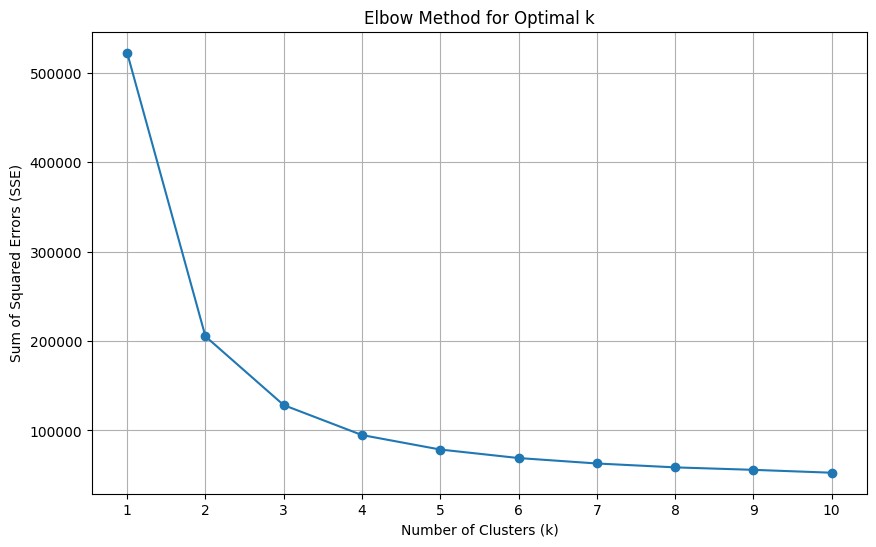

In [15]:
# Prepare the data for clustering by dropping NaNs
cluster_data = data.dropna()

k_range = range(1, 11)  # You can adjust the upper limit

# Store the Sum of Squared Errors (SSE) for each k
sse = []

# Iterate through the range of k values
for k in k_range:
    kmeans = KMeans(n_clusters=k,
                    random_state=0,
                    n_init='auto')  # Recommended to set n_init explicitly
    try:
        kmeans.fit(cluster_data)
        sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center.
    except ValueError as e:
        print(f"ValueError encountered with k={k}: {e}")
        sse.append(float('inf')) # Append infinity or a large value to indicate failure

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Apply pre-defined centroids.

In [ ]:
# rsi == 70 means stocks in upwards momentum
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

In [18]:
from sklearn.cluster import KMeans

if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-05-31 ADANIPORTS.NS         -0.000683  50.679145  5.755937  5.804539   
           ASIANPAINT.NS         -0.001614  58.333512  6.940039  6.978379   
           AUROPHARMA.NS         -0.001037  44.120145  6.198869  6.321087   
           AXISBANK.NS           -0.000010  53.918133  6.184008  6.216382   
           BAJFINANCE.NS         -0.000073  58.527416  7.089447  7.144502   
...                                    ...        ...       ...       ...   
2025-04-30 VEDL.NS                0.000261  48.623640  5.895122  6.021814   
           WIPRO.NS               0.000151  39.193971  5.437802  5.506651   
           YESBANK.NS             0.000157  50.298110  2.868447  2.929368   
           INDIGO.NS              0.000232  57.263377  8.498935  8.565136   
           BANDHANBNK.NS          0.000289  59.897401  4.958617  5.067651   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-05-31 ADANIPORTS.NS  5.853142 -0.565906 -0.092688   0.034483  -0.000884   
           ASIANPAINT.NS  7.016719 -0.857657  0.136110   0.027444   0.035558   
           AUROPHARMA.NS  6.443305 -0.114723 -1.206616  -0.053729  -0.077861   
           AXISBANK.NS    6.248756 -1.092474 -0.022809   0.008633   0.023412   
           BAJFINANCE.NS  7.199556 -1.061885 -0.098911   0.039766   0.064462   
...                            ...       ...       ...        ...        ...   
2025-04-30 VEDL.NS        6.148506  1.323767 -1.156573  -0.095382   0.030504   
           WIPRO.NS       5.575500  1.482988 -2.249849  -0.079123  -0.067369   
           YESBANK.NS     2.990289 -0.850021  0.110041   0.049763   0.028548   
           INDIGO.NS      8.631336  3.656736  2.437563   0.026225   0.082807   
           BANDHANBNK.NS  5.176685 -1.031126  0.556697   0.132212   0.083065   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-05-31 ADANIPORTS.NS   0.039563   0.033678   0.028628    0.048447   
           ASIANPAINT.NS   0.039733   0.028973  -0.000369    0.013750   
           AUROPHARMA.NS  -0.053539  -0.041584  -0.034770   -0.025548   
           AXISBANK.NS     0.004845   0.015097  -0.016457    0.000590   
           BAJFINANCE.NS   0.061888   0.062984   0.020946    0.047739   
...                             ...        ...        ...         ...   
2025-04-30 VEDL.NS        -0.017054  -0.013823  -0.000116    0.012354   
           WIPRO.NS       -0.081737  -0.018738  -0.006421    0.005286   
           YESBANK.NS     -0.026891  -0.023200  -0.043772   -0.031909   
           INDIGO.NS       0.066757   0.044077   0.017965    0.023290   
           BANDHANBNK.NS   0.030421  -0.015785  -0.029288   -0.010008   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-05-31 ADANIPORTS.NS  0.276405  0.019138  0.472312  0.251513 -0.507095   
           ASIANPAINT.NS  0.119790  0.246890  0.173985  0.413898 -0.311674   
           AUROPHARMA.NS  0.733618 -0.036304 -0.256178  0.045463 -0.294557   
           AXISBANK.NS    0.761360  0.127728  0.366873 -0.361687  0.085858   
           BAJFINANCE.NS  0.554100  0.130599  0.752954 -0.348843 -0.367881   
...                            ...       ...       ...       ...       ...   
2025-04-30 VEDL.NS       -1.492639  2.242208  0.043744  1.974841 -2.856775   
           WIPRO.NS       0.741610 -0.084365 -0.110768 -0.365673 -0.134672   
           YESBANK.NS    -0.045974  2.032043 -0.761720  0.860807 -0.157939   
           INDIGO.NS      0.559774 -0.496142  0.525692 -0.512278 -0.663858   
           BANDHANBNK.NS -0.058854 -0.519153  0.685955 -0.914503 -0.629784   

                  

In [19]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


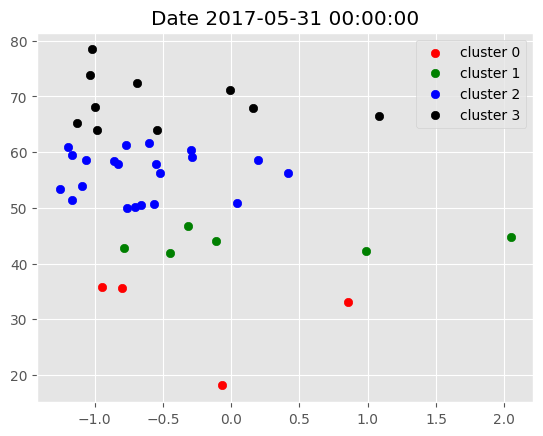

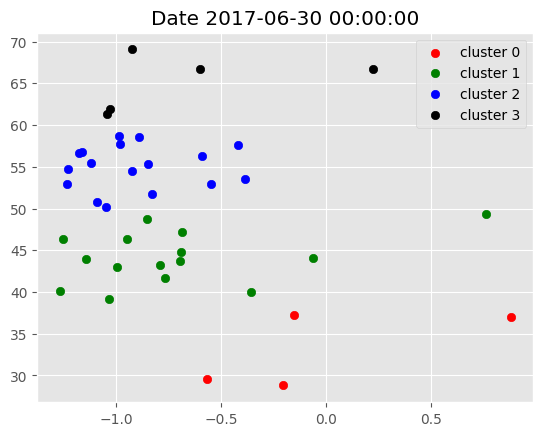

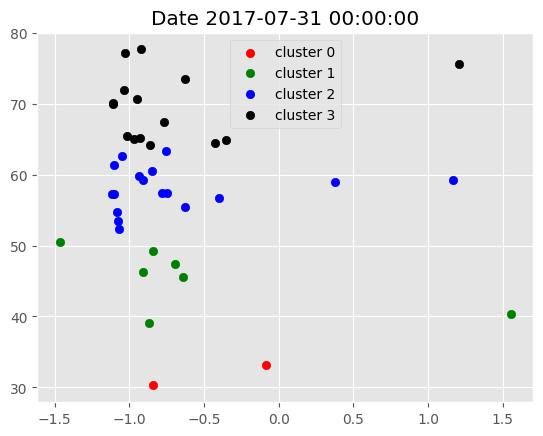

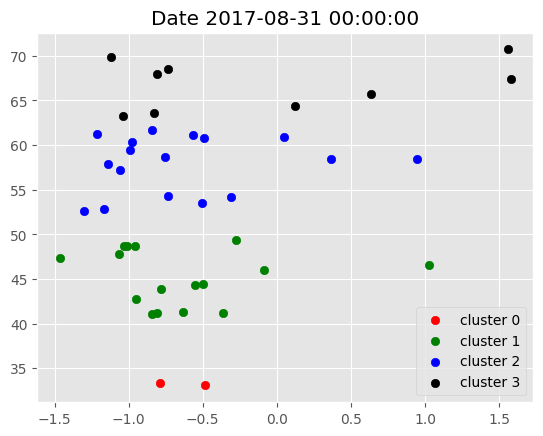

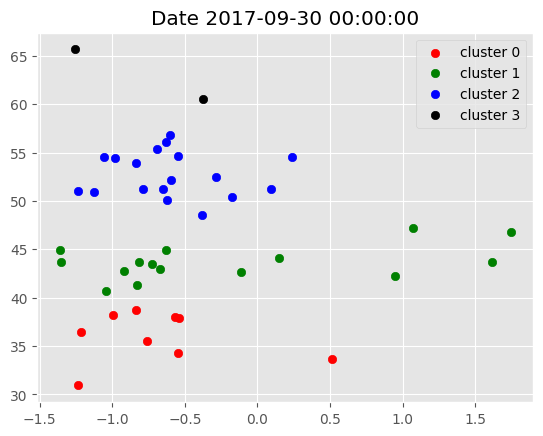

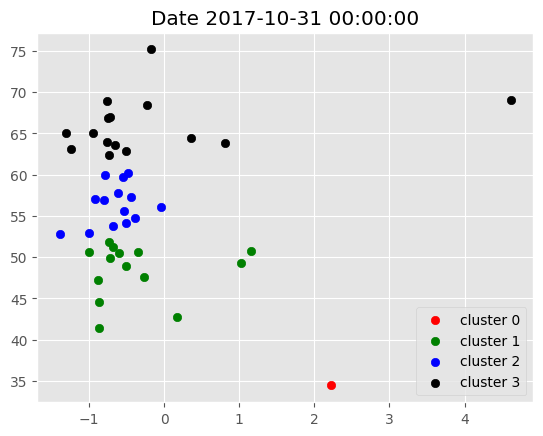

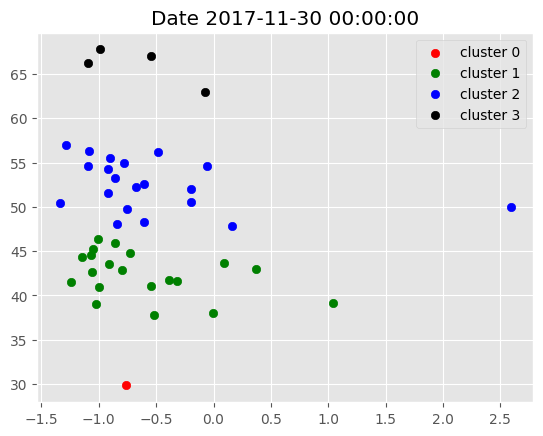

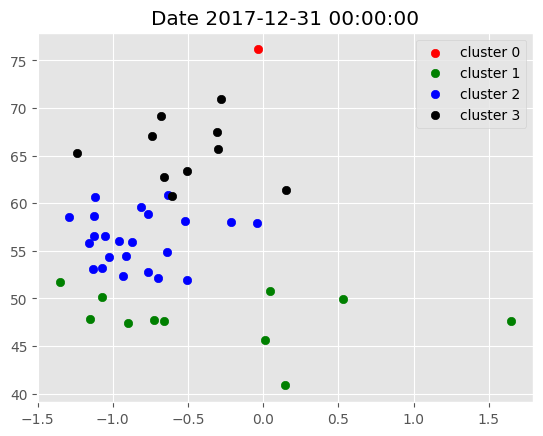

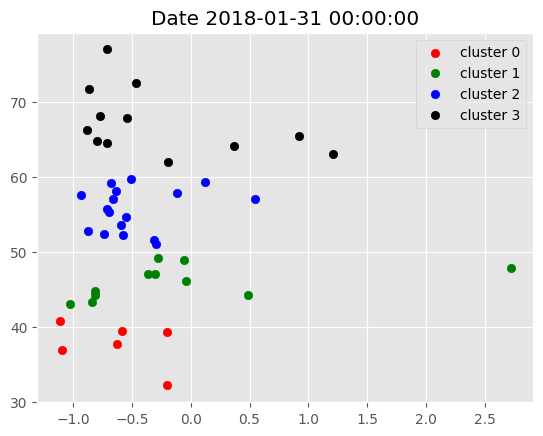

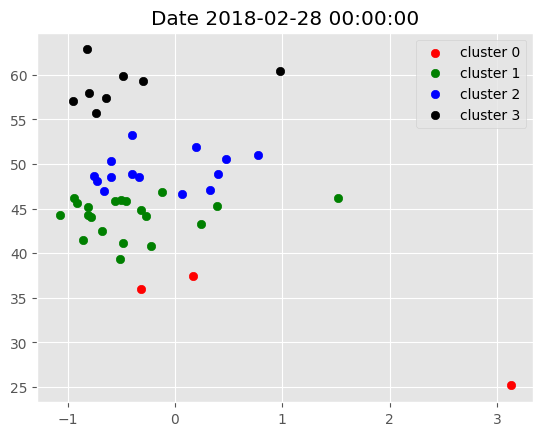

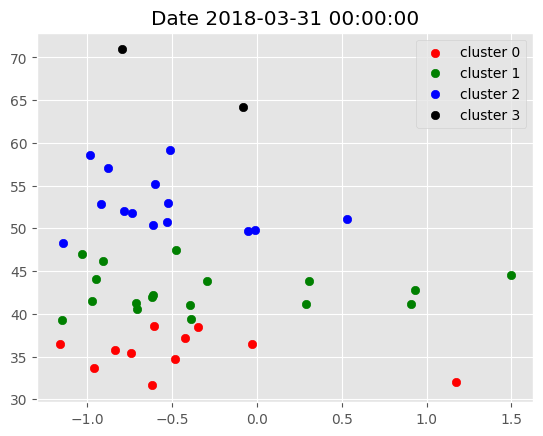

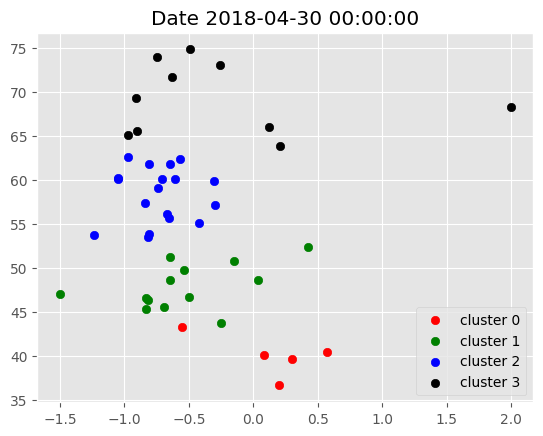

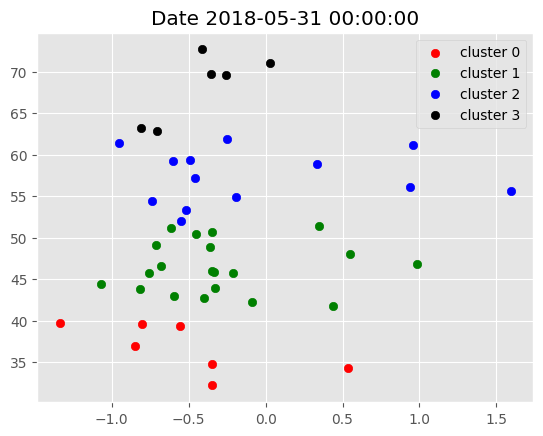

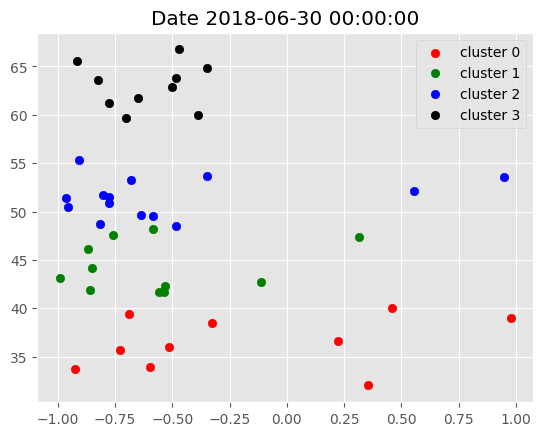

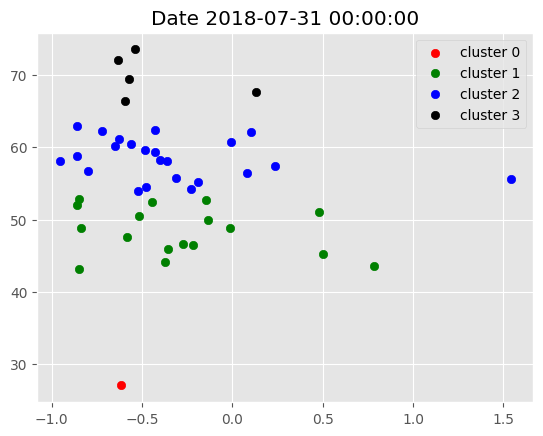

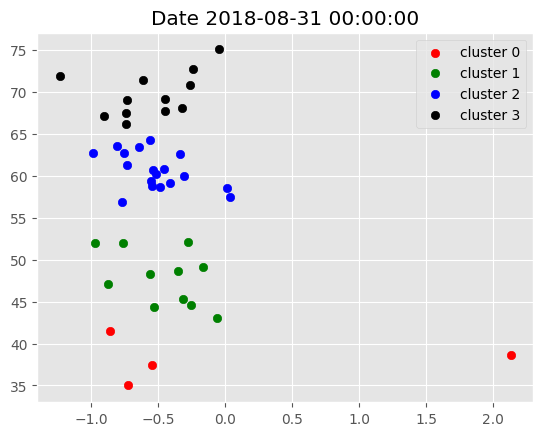

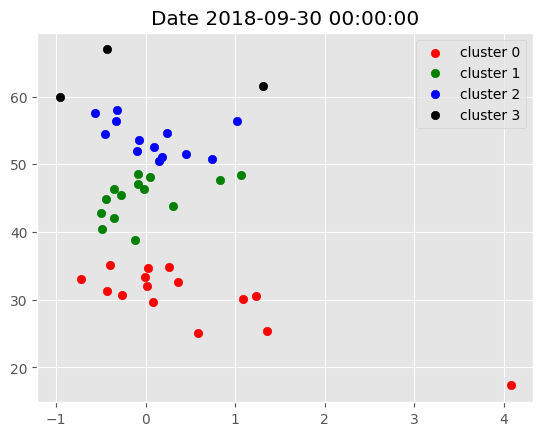

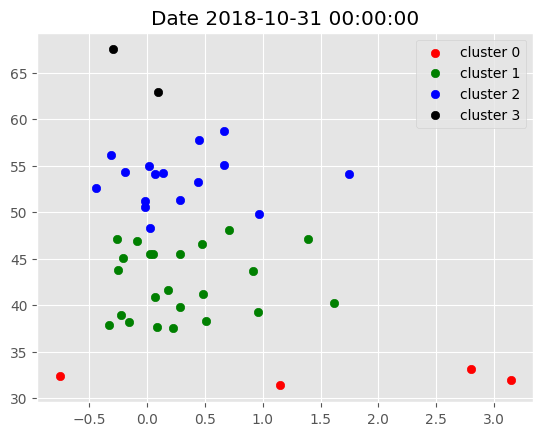

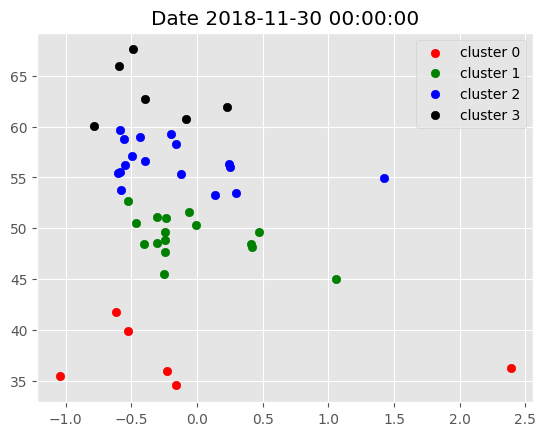

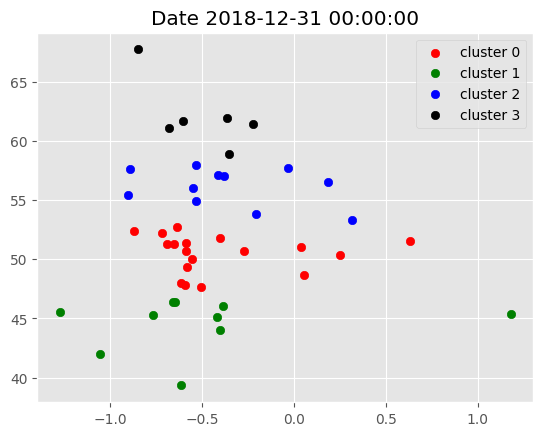

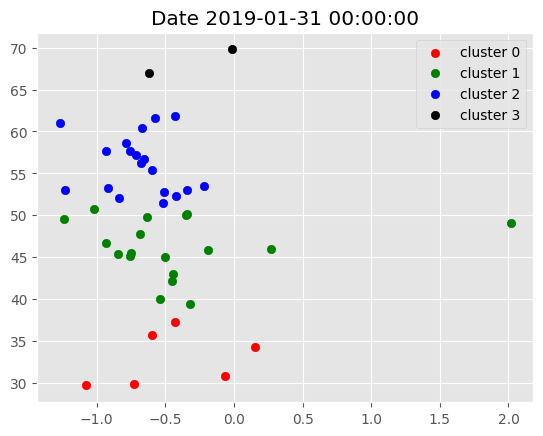

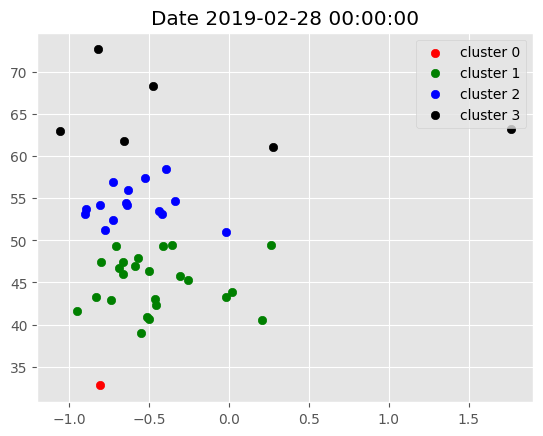

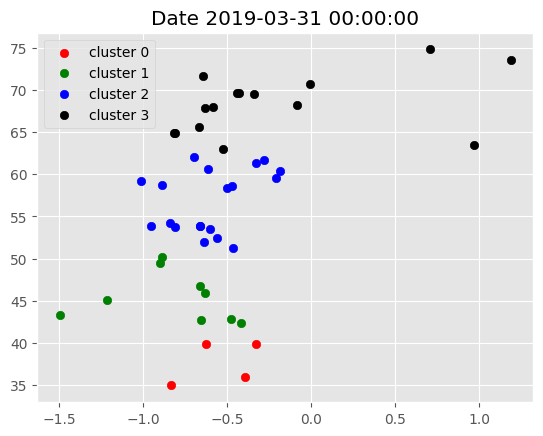

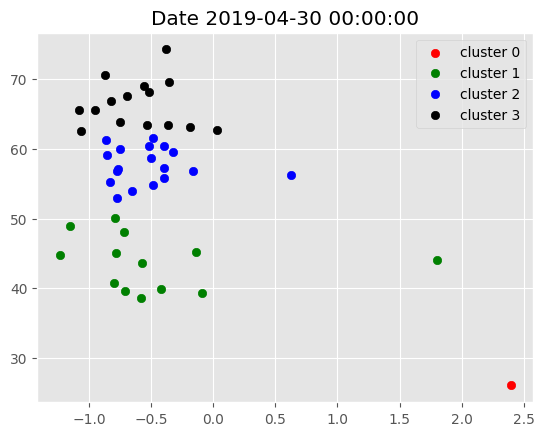

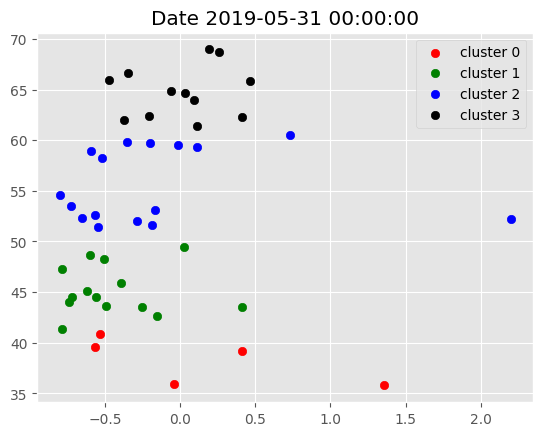

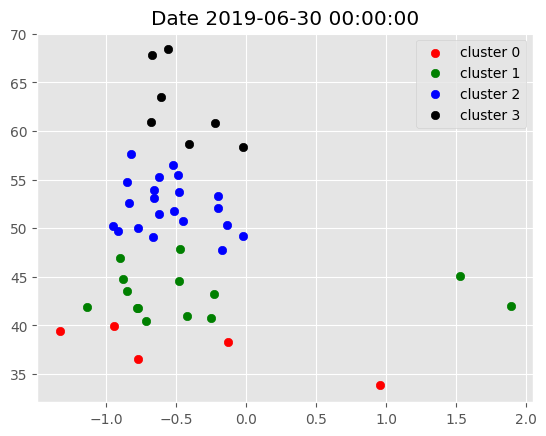

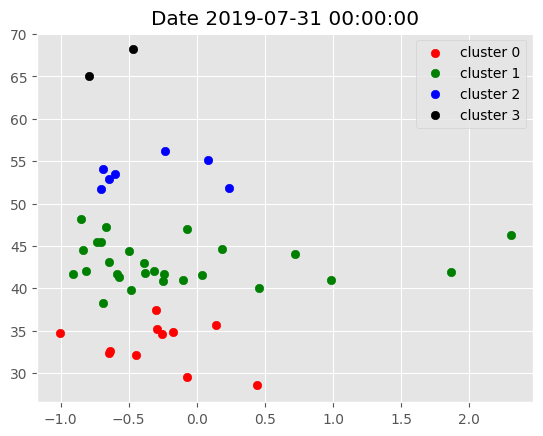

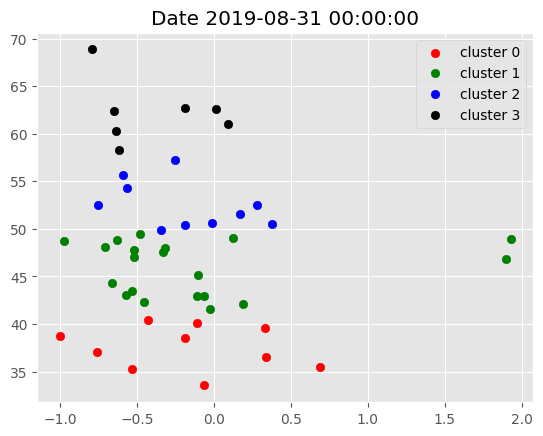

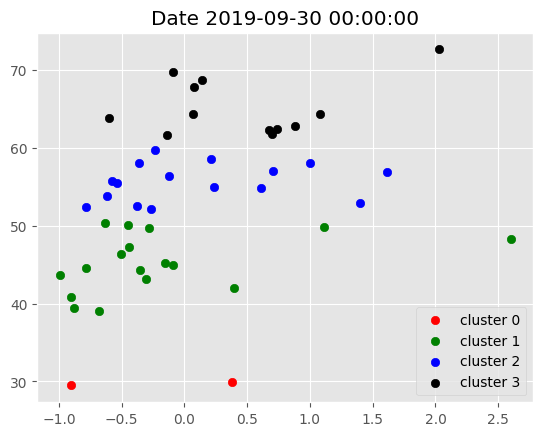

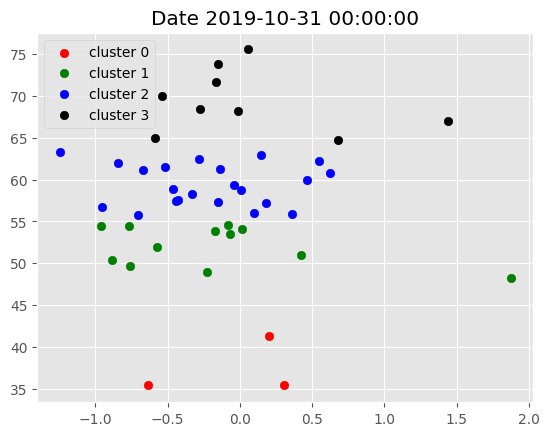

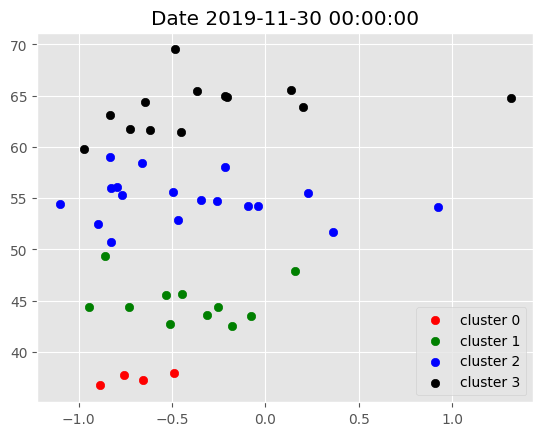

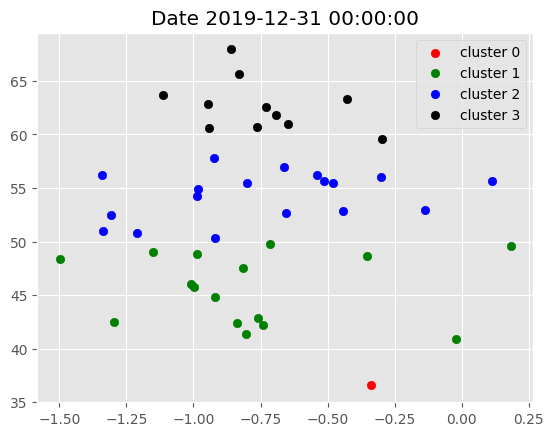

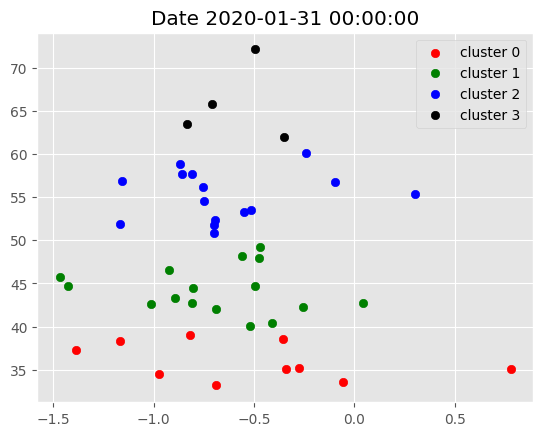

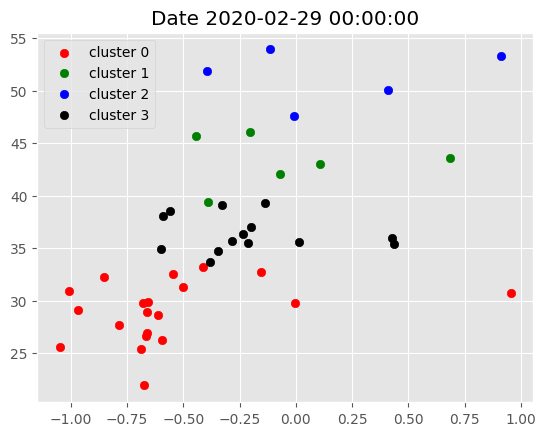

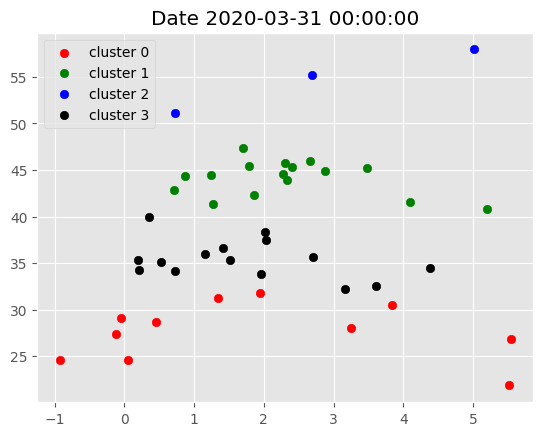

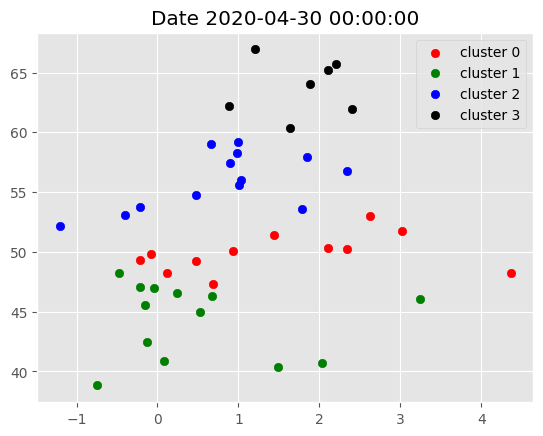

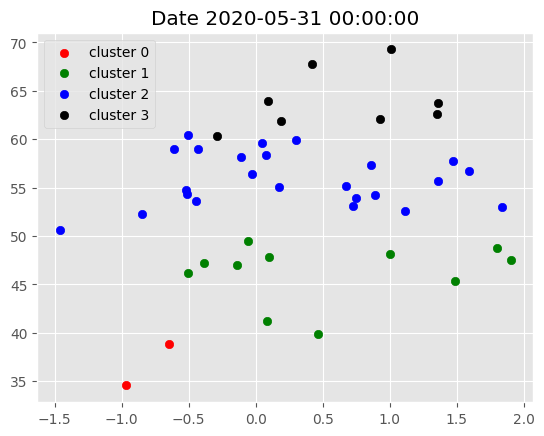

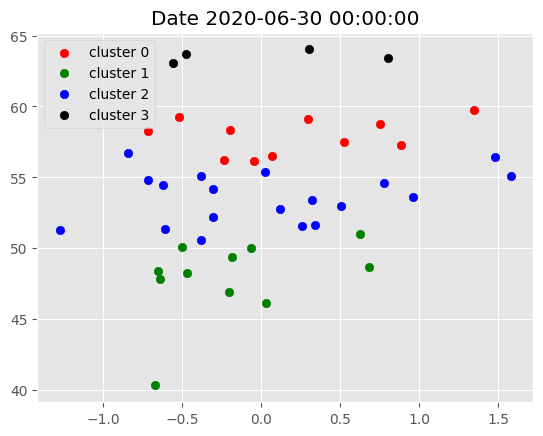

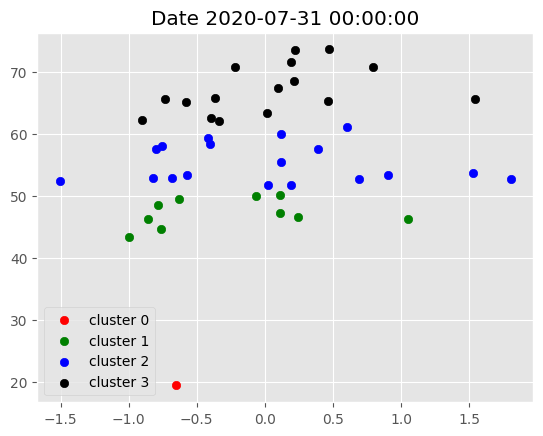

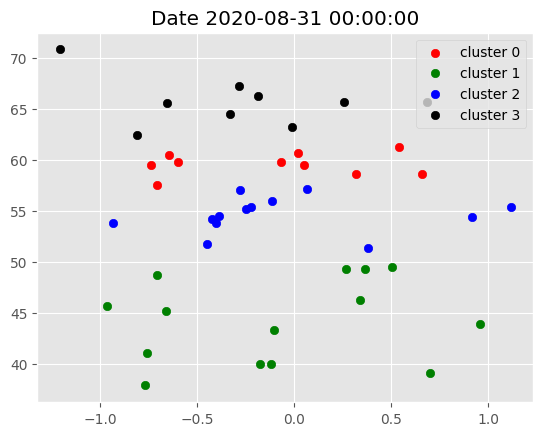

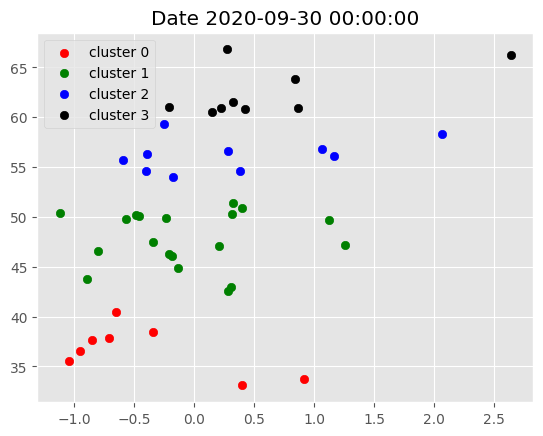

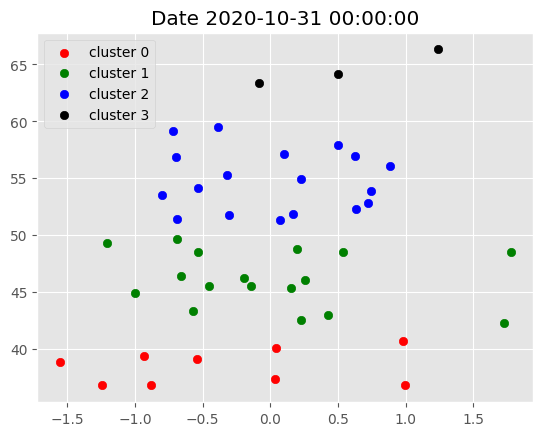

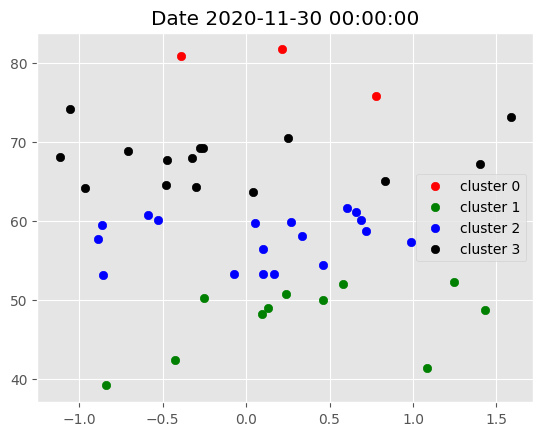

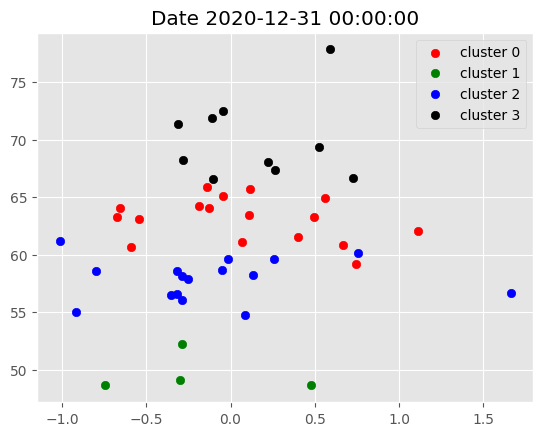

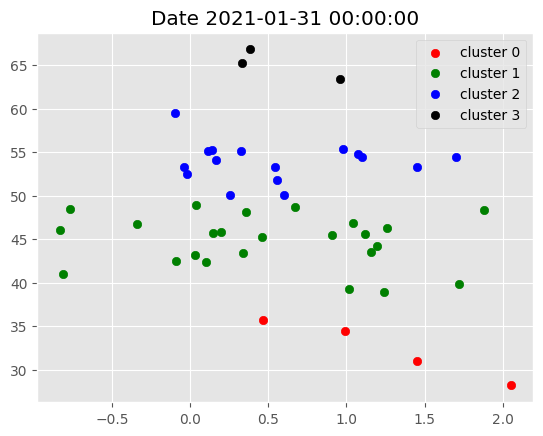

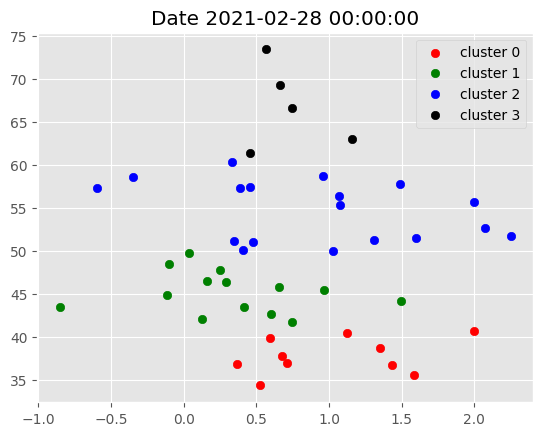

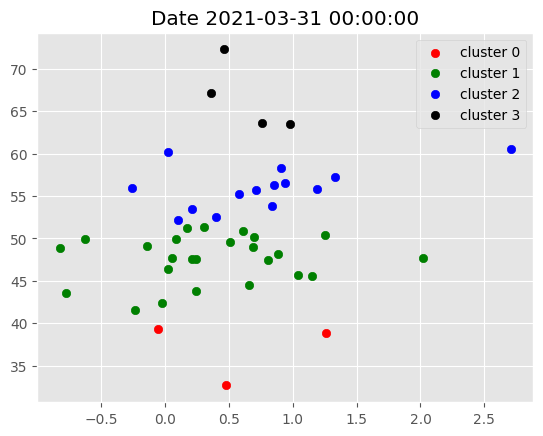

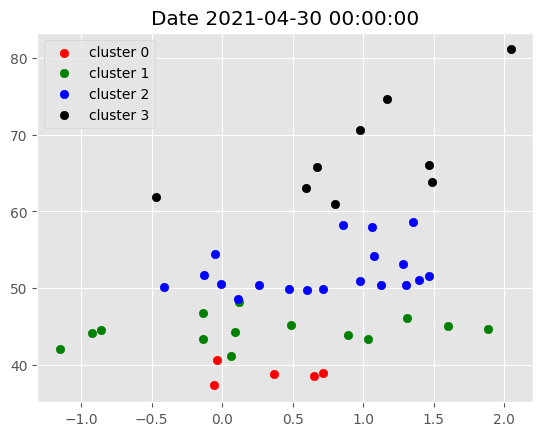

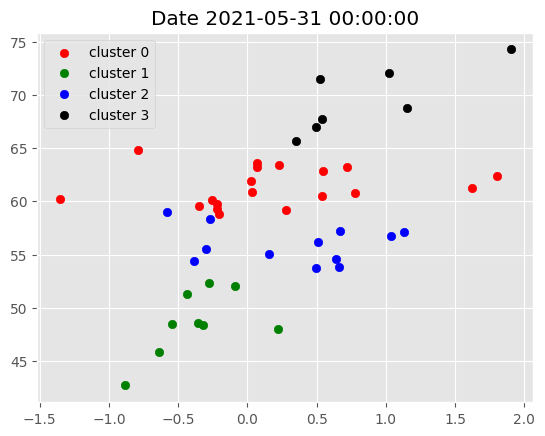

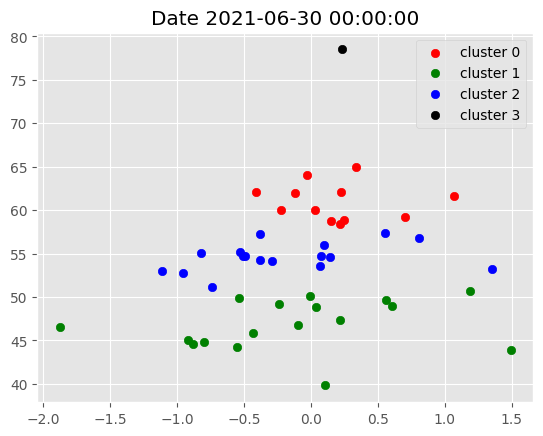

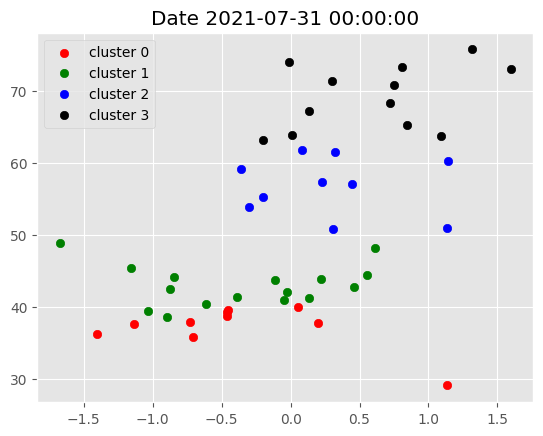

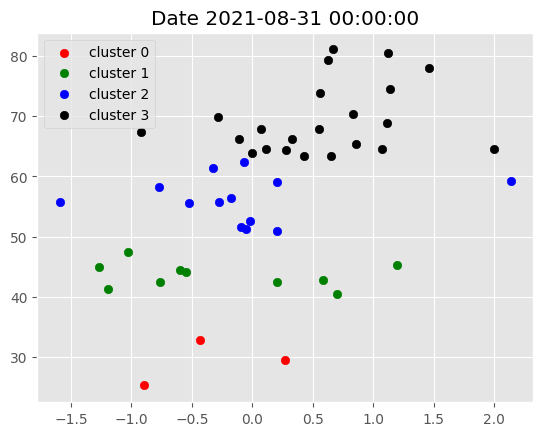

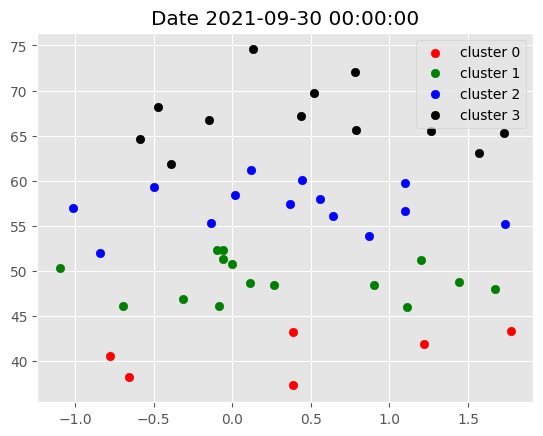

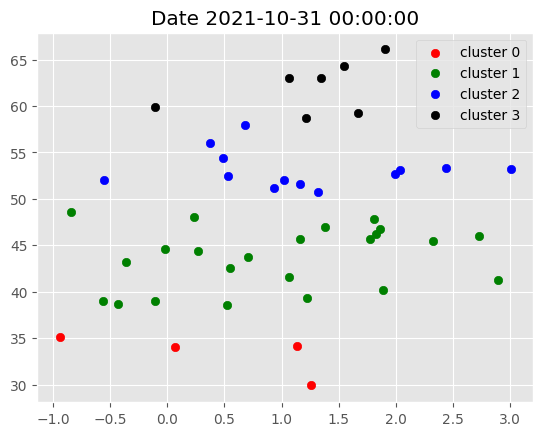

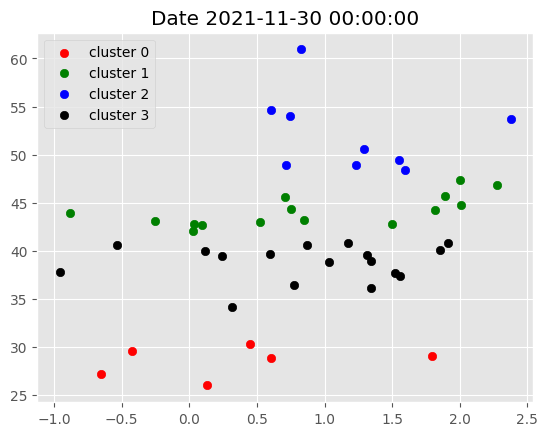

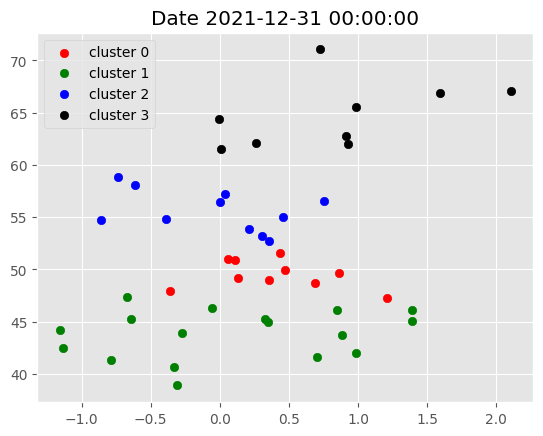

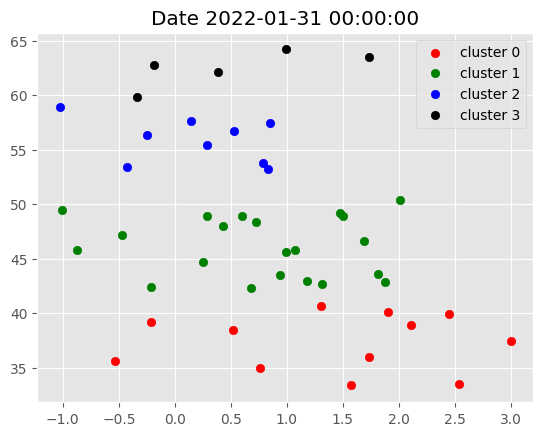

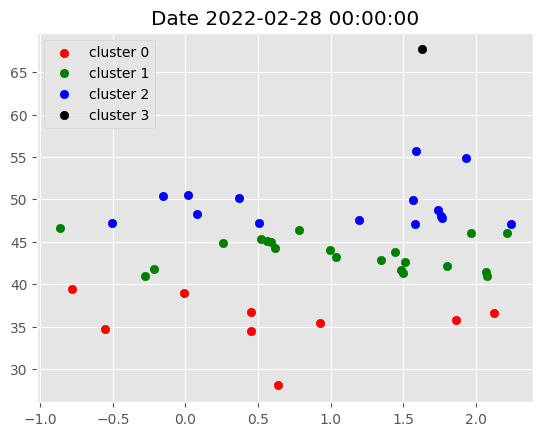

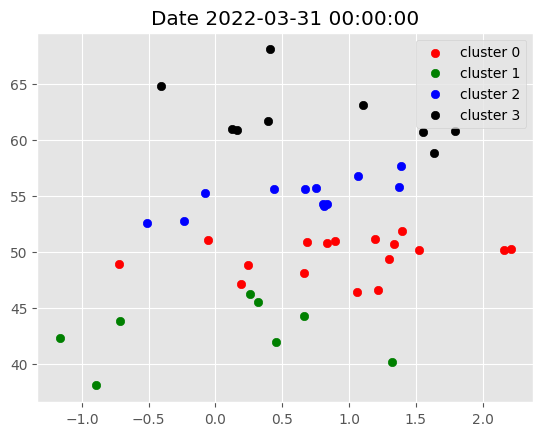

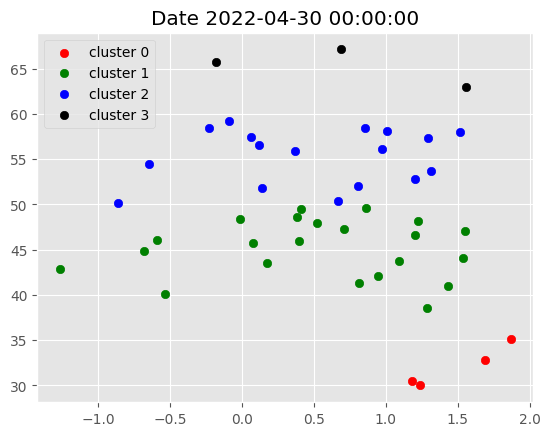

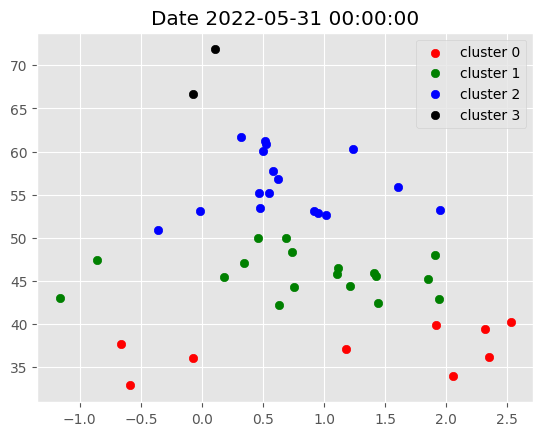

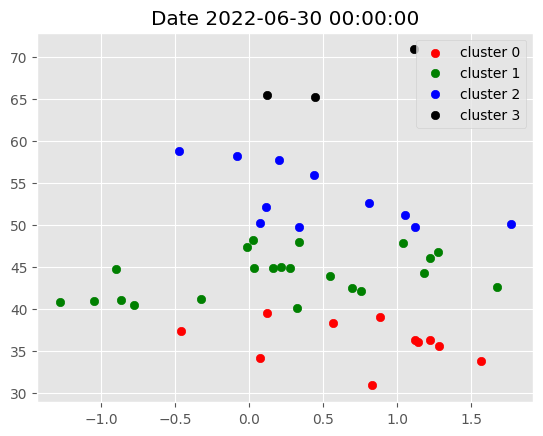

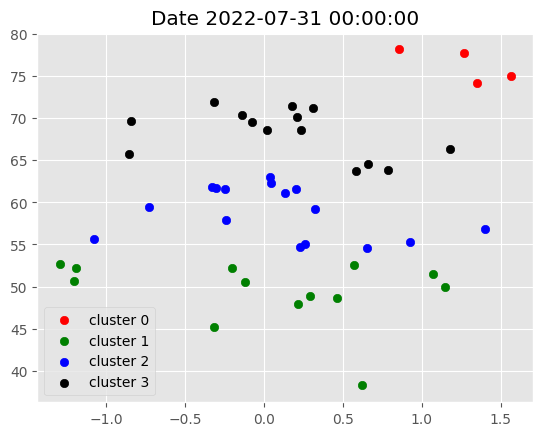

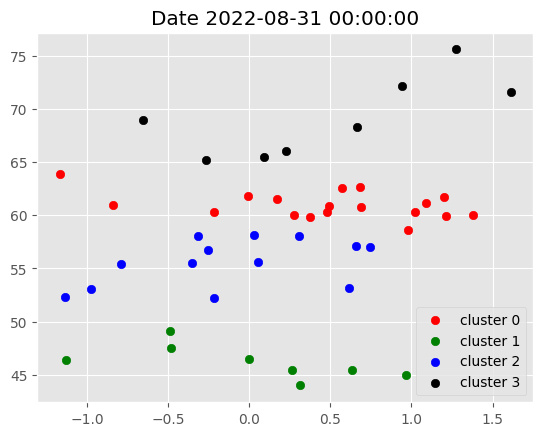

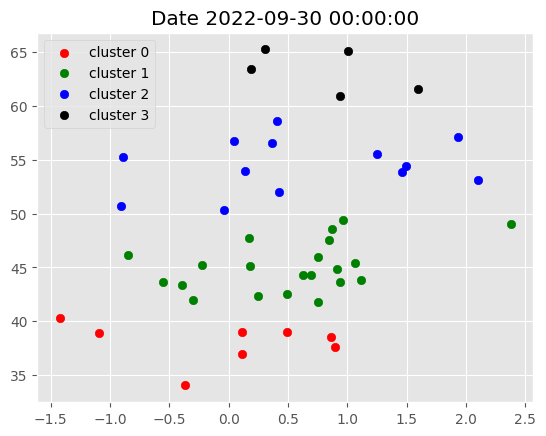

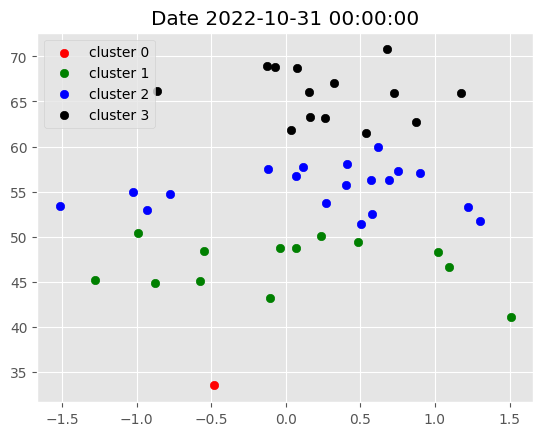

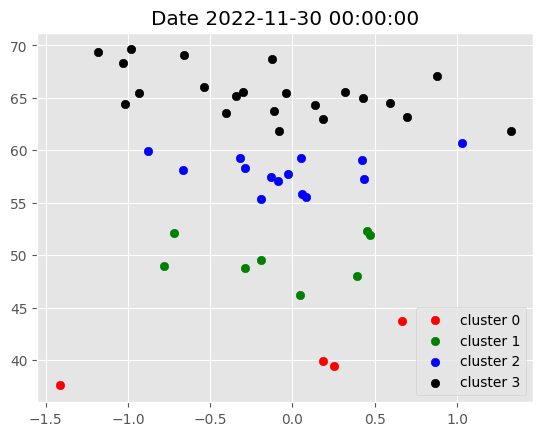

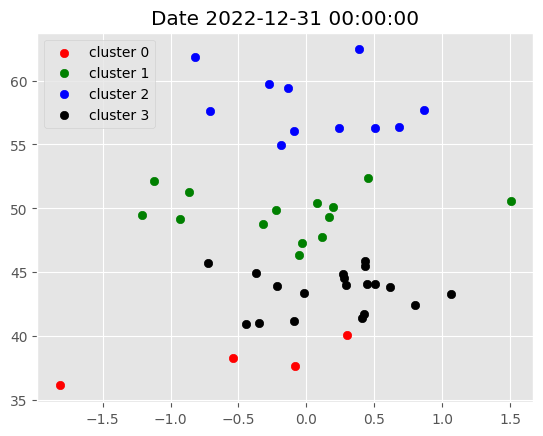

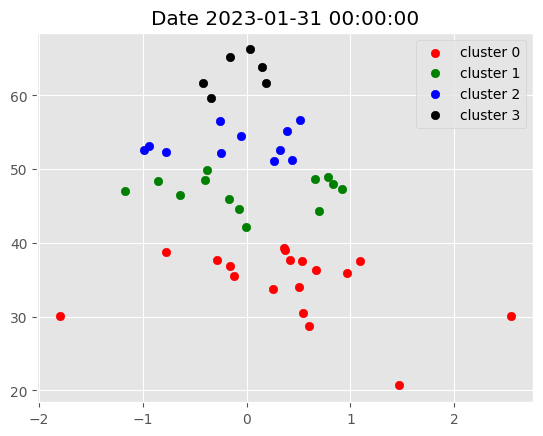

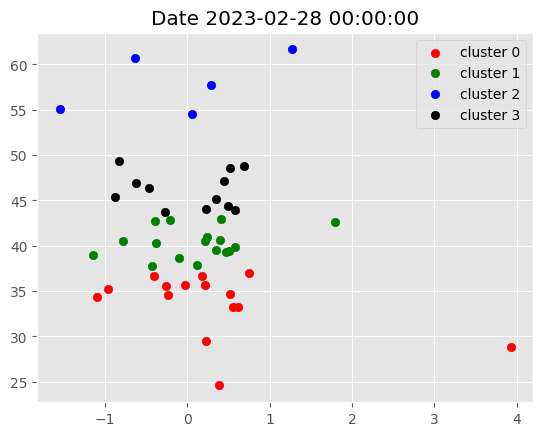

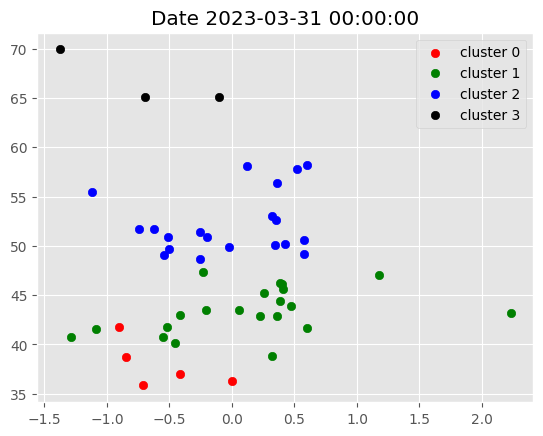

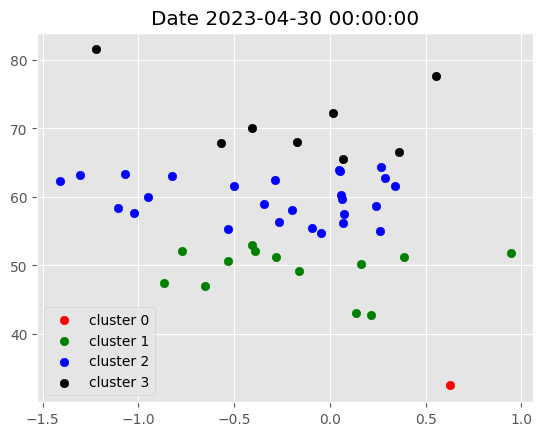

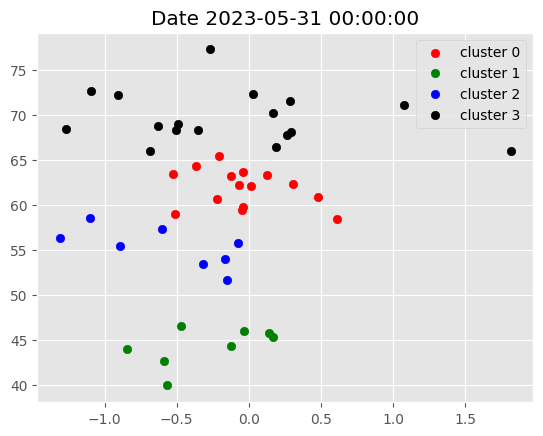

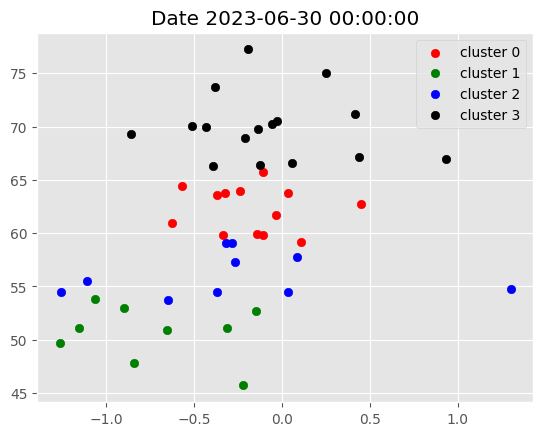

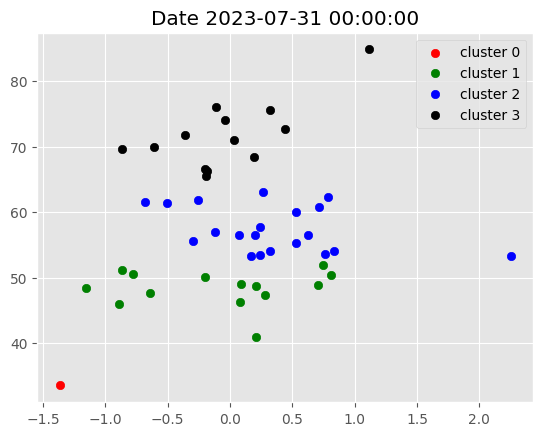

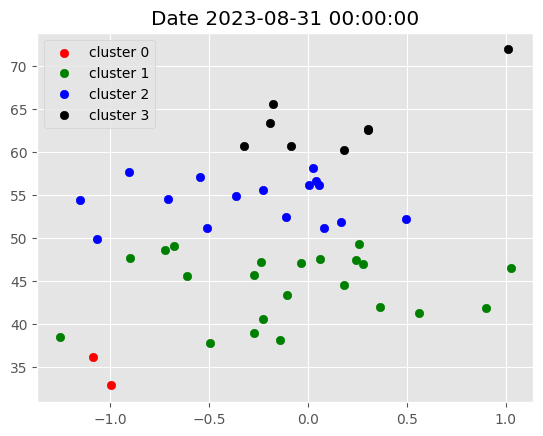

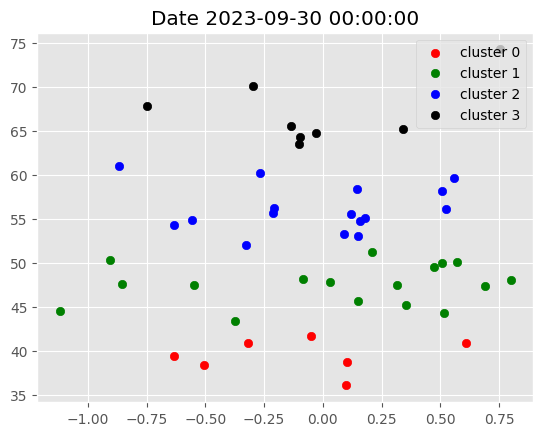

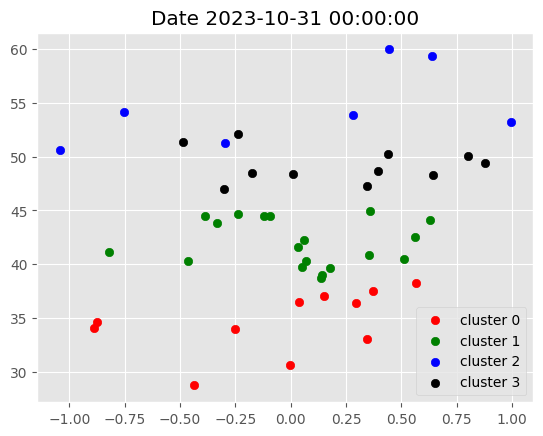

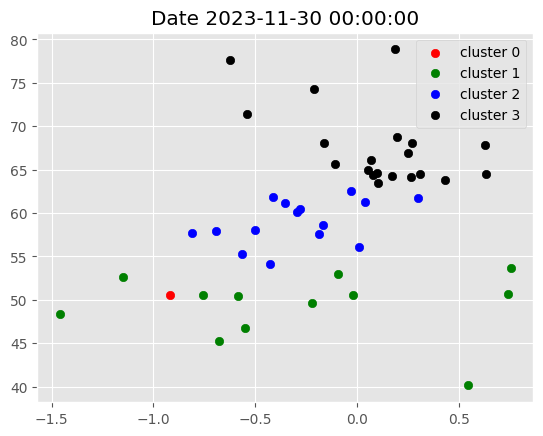

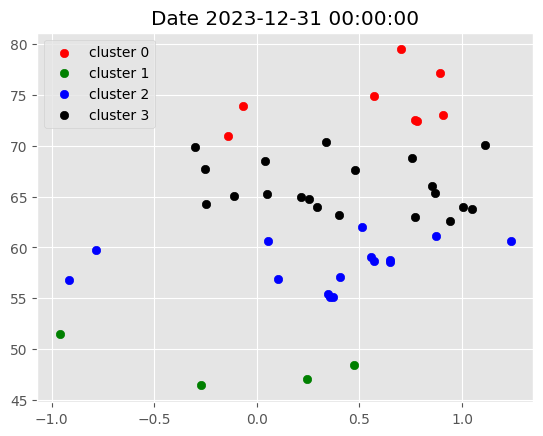

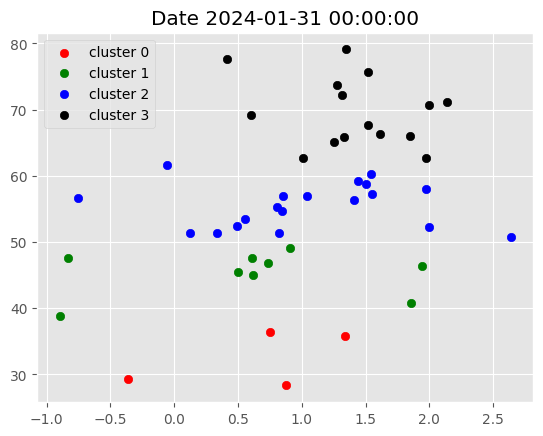

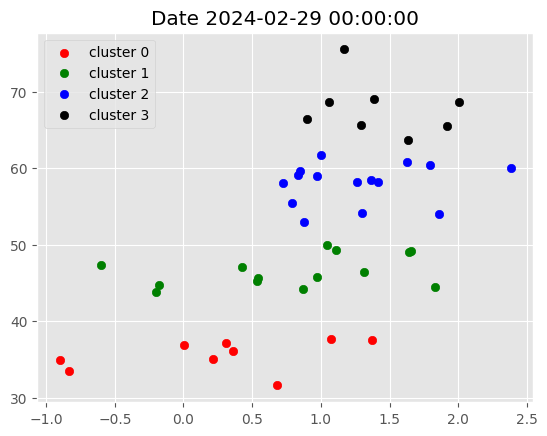

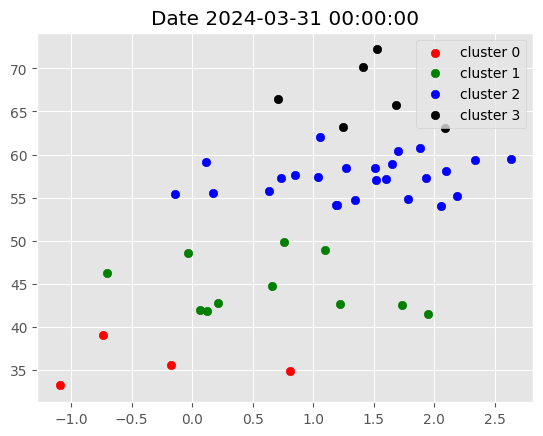

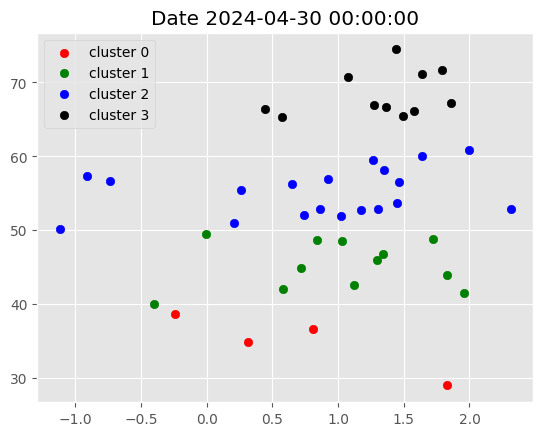

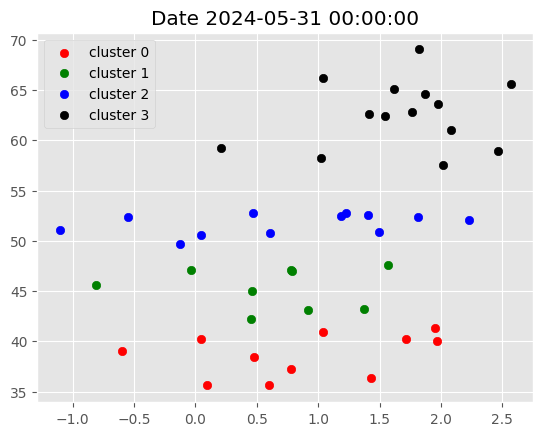

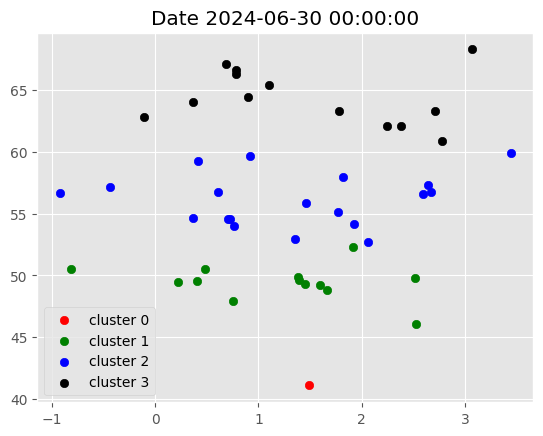

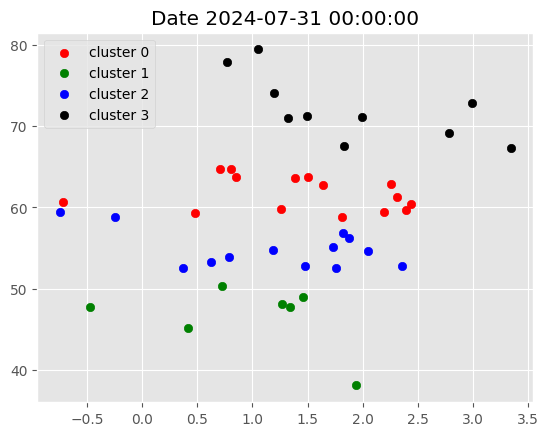

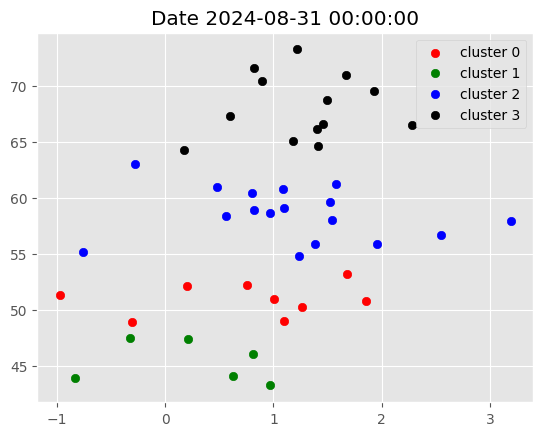

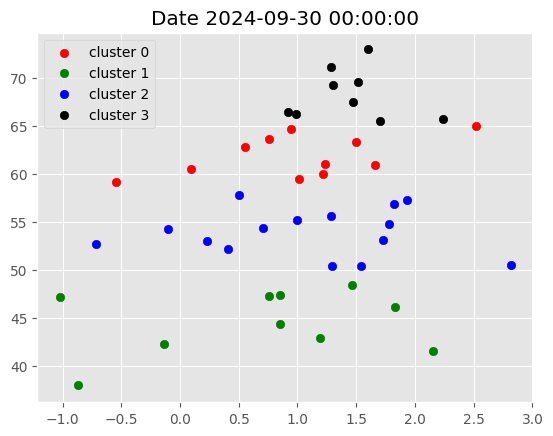

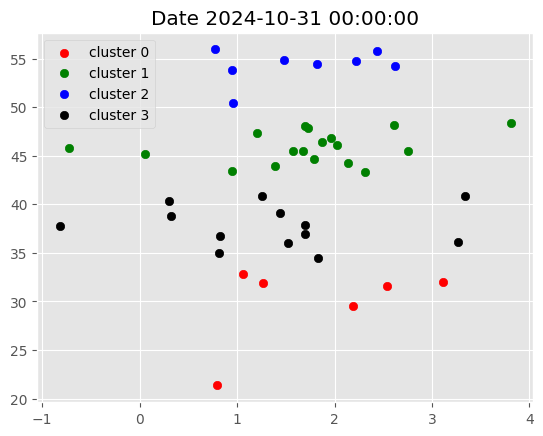

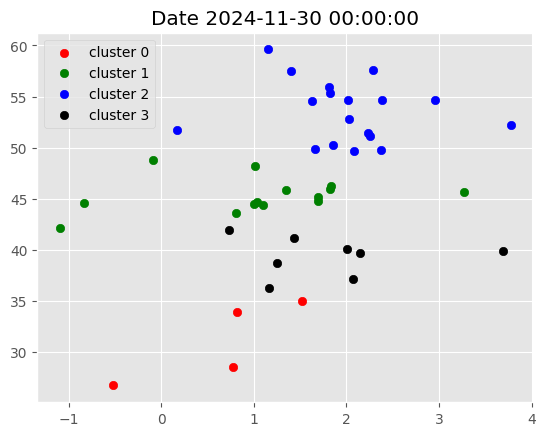

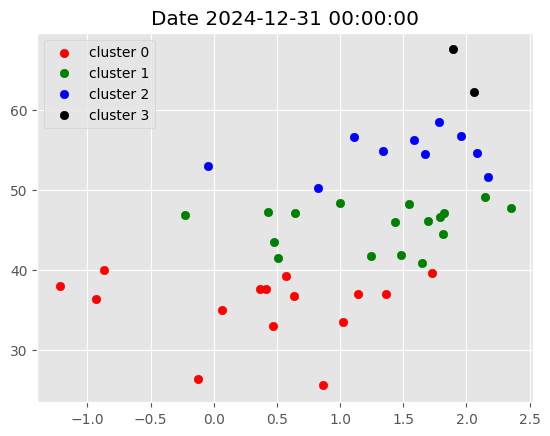

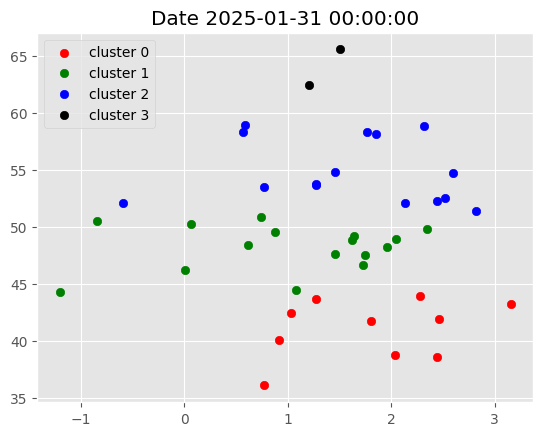

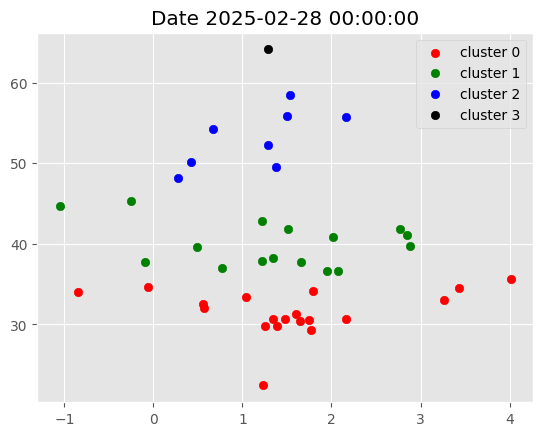

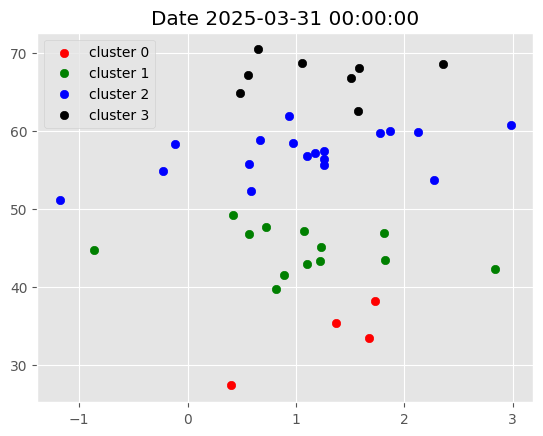

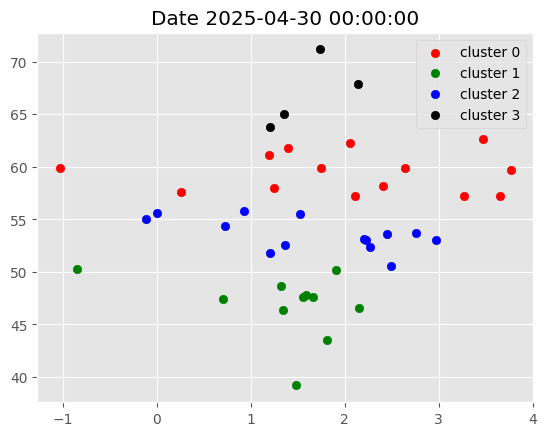

In [20]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 2.


In [21]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1) # move by day 1 as all are end of month, this will make them first day of month

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    try:
        # Get stocks for this month if available in filtered_df
        stocks = filtered_df.xs(d, level=0).index.tolist()
        if stocks:  # Only add if stocks exist for this month
            fixed_dates[d.strftime('%Y-%m-%d')] = stocks
    except KeyError:
        # If no data for this month, skip or optionally assign fallback tickers
        pass
    # fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-06-01': ['HDFCBANK.NS',
  'HEROMOTOCO.NS',
  'HINDUNILVR.NS',
  'ICICIBANK.NS',
  'ITC.NS',
  'KOTAKBANK.NS',
  'M&M.NS',
  'MARUTI.NS',
  'UPL.NS',
  'WIPRO.NS'],
 '2017-07-01': ['AUROPHARMA.NS',
  'BHARTIARTL.NS',
  'HDFCBANK.NS',
  'ITC.NS',
  'TATASTEEL.NS'],
 '2017-08-01': ['ADANIPORTS.NS',
  'BAJFINANCE.NS',
  'EICHERMOT.NS',
  'HDFCBANK.NS',
  'HINDALCO.NS',
  'HINDUNILVR.NS',
  'INDUSINDBK.NS',
  'KOTAKBANK.NS',
  'MARUTI.NS',
  'RELIANCE.NS',
  'SBIN.NS',
  'TATASTEEL.NS',
  'VEDL.NS',
  'WIPRO.NS',
  'YESBANK.NS'],
 '2017-09-01': ['BPCL.NS',
  'HINDPETRO.NS',
  'HINDUNILVR.NS',
  'IOC.NS',
  'JSWSTEEL.NS',
  'JUBLFOOD.NS',
  'TATASTEEL.NS',
  'VEDL.NS',
  'WIPRO.NS'],
 '2017-10-01': ['ONGC.NS', 'TECHM.NS'],
 '2017-11-01': ['ADANIPORTS.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'CIPLA.NS',
  'DLF.NS',
  'JUBLFOOD.NS',
  'LT.NS',
  'MARUTI.NS',
  'ONGC.NS',
  'PNB.NS',
  'RELIANCE.NS',
  'SBIN.NS',
  'TCS.NS',
  'TECHM.NS',
  'ULTRACEMCO.NS'],
 '2017-12-01': ['BIOCON.NS', 'D

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [22]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# def optimize_weights(prices, lower_bound=0):
#     filtered_prices = prices.loc[:, prices.var() > 0]
#     returns = expected_returns.mean_historical_return(prices=filtered_prices,
#                                                       frequency=252)
    
#     cov = risk_models.sample_cov(prices=filtered_prices,
#                                  frequency=252)
    
#     ef = EfficientFrontier(expected_returns=returns,
#                            cov_matrix=cov,
#                            weight_bounds=(lower_bound, .1), # max wt to one stock is 10% for diversification purpose
#                            solver='SCS')
    
#     weights = ef.max_sharpe()
    
#     return ef.clean_weights()


def optimize_weights(prices, lower_bound=0):
    # Filter assets with zero variance (constant assets)
    filtered_prices = prices.loc[:, prices.var() > 0]
    
    # Calculate historical returns
    returns = expected_returns.mean_historical_return(prices=filtered_prices, frequency=252)
    
    # Estimate the covariance matrix with sample covariance
    cov = risk_models.sample_cov(prices=filtered_prices, frequency=252)
    
    # Regularize the covariance matrix to ensure positive semi-definiteness
    cov += np.eye(cov.shape[0]) * 1e-6  # Adding a small value to the diagonal
    
    # Create the EfficientFrontier object with the desired optimization objective
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, 0.1),  # max weight for a single asset
                           solver='SCS')
    
    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()
    
    # Clean the weights and return
    return ef.clean_weights()



* Download Fresh Daily Prices Data only for short listed stocks.

In [24]:
stocks = data.index.get_level_values('ticker').unique().tolist()  # get list of tickers

new_df = yf.download(tickers=stocks,
                     # get stock date 1 year before to make portfolio for year 2017
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     auto_adjust=False,
                     end=data.index.get_level_values('date').unique()[-1])

new_df.head()

[*********************100%***********************]  53 of 53 completed


Price        Adj Close                                            \
Ticker     ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                               
2016-05-31   38.860142    183.749634   1329.086914    919.404297   
2016-06-01   40.087021    193.455902   1372.140381    953.805725   
2016-06-02   40.300392    196.229126   1360.442871    955.999512   
2016-06-03   38.433403    195.607544   1326.562866    957.166504   
2016-06-06   38.566753    194.794693   1314.476685    958.100037   

Price                                                             \
Ticker     AUROPHARMA.NS AXISBANK.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                               
2016-05-31    748.135803  502.643799    181.454361    740.132324   
2016-06-01    751.517822  499.472961    179.251770    745.359985   
2016-06-02    751.565552  511.570740    184.519028    776.779114   
2016-06-03    752.422974  529.424744    184.957565    770.439697   
2016-06-06    742.276978  519.863586    185.974152    758.204529   

Price                                   ...        Volume               \
Ticker     BANDHANBNK.NS BHARTIARTL.NS  ... TATAMOTORS.NS TATASTEEL.NS   
Date                                    ...                              
2016-05-31           NaN    302.489075  ...     110744326    105401750   
2016-06-01           NaN    312.689728  ...      10389215     68046412   
2016-06-02           NaN    315.229126  ...      13674434     58494475   
2016-06-03           NaN    308.299530  ...      11672544     92705451   
2016-06-06           NaN    300.207947  ...       9356808     52163250   

Price                                                                    \
Ticker       TCS.NS TECHM.NS  TITAN.NS ULTRACEMCO.NS   UPL.NS   VEDL.NS   
Date                                                                      
2016-05-31  3722608  2896981  27065544        237511  4957333  26753083   
2016-06-01  1911942  1093756   1519865        124069  2379495  10583106   
2016-06-02  1408756  1862166   1144323        100251  5576956  10946742   
2016-06-03  1554922  1706048   1126862        169178  3974541   7715226   
2016-06-06  1322026  1614098    908115        153326  3329179   9878216   

Price                            
Ticker      WIPRO.NS YESBANK.NS  
Date                             
2016-05-31  11040471   57458505  
2016-06-01   5452990   12213510  
2016-06-02  13762753   14912165  
2016-06-03   7088563   15162245  
2016-06-06  10304205   16298060  

[5 rows x 318 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

#### Testing before building thee function

In [ ]:
# optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
optimization_df = new_df['2016-11-01':'2017-10-30']['Adj Close'][cols]
optimization_df

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    weights = optimize_weights(prices=optimization_df, 
                              lower_bound=round((1/len(optimization_df.columns))*0.5, 2))
    weights = pd.DataFrame(weights, index=pd.Series(0))


In [ ]:
weights = optimize_weights(prices=optimization_df, 
                          lower_bound=round((1/len(optimization_df.columns))*0.5, 2))
weights = pd.DataFrame(weights, index=pd.Series(0))
weights

In [ ]:
temp_df = returns_dataframe['2017-11-01':'2017-11-30']
temp_df.columns.name = None # had to remove ticker name as it interferes with our stacking
temp_df.head()

In [ ]:
temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
              left_index=True,
              right_index=True)\
    .reset_index().set_index(['Date', 'index']).unstack().stack()

In [26]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:

        # end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        # cols = fixed_dates[start_date]
        # optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        # optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

            temp_df = returns_dataframe[start_date:end_date]
            temp_df.columns.name = None
            temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                       .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                              left_index=True,
                              right_index=True)\
                       .reset_index().set_index(['Date', 'index']).unstack().stack()
    
            temp_df.index.names = ['date', 'ticker']
    
            temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    
            temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    
            portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights

,Strategy Return
date,
2017-07-03,0.015307
2017-07-04,-0.008466
2017-07-05,-0.004834
2017-07-06,0.010599
2017-07-07,0.005305
...,...
2025-04-23,-0.002865
2025-04-24,-0.002852
2025-04-25,-0.018396


In [ ]:
## gives smooth graph of returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        success = False

        try:
            optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1 / (len(optimization_df.columns) * 0.5), 3)
            )
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except Exception as e:
            print(f"[{start_date}] Optimization failed: {e}")
            # Attempt fallback using equal weights
            try:
                optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
                weights = pd.DataFrame(
                    [1 / len(cols)] * len(cols),
                    index=cols,
                    columns=pd.Series(0)
                ).T
            except Exception as fallback_e:
                print(f"[{start_date}] Equal-weight fallback failed: {fallback_e}")
                continue  # Skip this date entirely

        # Compute weighted returns
        temp_df = returns_dataframe[start_date:end_date]
        temp_df.columns.name = None

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True, right_index=True)\
            .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as outer_e:
        print(f"[{start_date}] Skipped due to error: {outer_e}")

# Drop duplicate index entries (if any)
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

portfolio_df


In [ ]:
portfolio_df


In [ ]:
portfolio_df.plot()

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [27]:
# spy = yf.download(tickers='SPY',
#                   start='2015-01-01',
#                   end=dt.date.today())

# spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

# portfolio_df = portfolio_df.merge(spy_ret,
#                                   left_index=True,
#                                   right_index=True)

# portfolio_df
# ticker = 'SBIETFQLTY.NS'
ticker = 'NETFNIF100.NS'

# Download NIFTY 200 benchmark data
nifty100 = yf.download(
    tickers=ticker,
    start='2017-01-01',
    end=dt.date.today(),
    auto_adjust=False
)

nifty100

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NETFNIF100.NS,NETFNIF100.NS,NETFNIF100.NS,NETFNIF100.NS,NETFNIF100.NS,NETFNIF100.NS
Date,,,,,,
2017-01-02,85.480003,85.480003,85.480003,85.480003,85.480003,28
2017-01-03,85.870003,85.870003,85.870003,85.870003,85.870003,110
2017-01-04,86.120003,86.120003,86.120003,86.120003,86.120003,1
2017-01-05,86.575401,86.575401,86.575401,86.575401,86.575401,0
2017-01-06,87.269997,87.269997,87.269997,87.120003,87.120003,37
...,...,...,...,...,...,...
2025-05-02,265.500000,265.500000,265.500000,265.500000,265.500000,0
2025-05-05,265.500000,265.500000,265.500000,265.500000,265.500000,0


In [28]:
# Drop the ticker level and keep only the price labels
nifty100.columns = nifty100.columns.get_level_values(0)
nifty100.columns.name = None  # Remove the column name (like 'Price')

nifty100.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2017-01-02,85.480003,85.480003,85.480003,85.480003,85.480003,28
2017-01-03,85.870003,85.870003,85.870003,85.870003,85.870003,110
2017-01-04,86.120003,86.120003,86.120003,86.120003,86.120003,1
2017-01-05,86.575401,86.575401,86.575401,86.575401,86.575401,0
2017-01-06,87.269997,87.269997,87.269997,87.120003,87.120003,37


In [30]:
# Calculate log returns and rename column
nifty100_ret = np.log(nifty100[['Adj Close']]).diff().dropna().rename(columns={'Adj Close': 'NIFTY100 Buy&Hold'})

# Merge with your strategy portfolio
portfolio_df = portfolio_df.merge(nifty100_ret, left_index=True, right_index=True)

portfolio_df

,Strategy Return,NIFTY100 Buy&Hold
2017-07-03,0.015307,0.006528
2017-07-04,-0.008466,-0.001085
2017-07-05,-0.004834,0.000000
2017-07-06,0.010599,0.005119
2017-07-07,0.005305,0.007143
...,...,...
2025-04-23,-0.002865,0.000000
2025-04-24,-0.002852,0.000000
2025-04-25,-0.018396,0.000000
2025-04-28,0.010471,0.000000


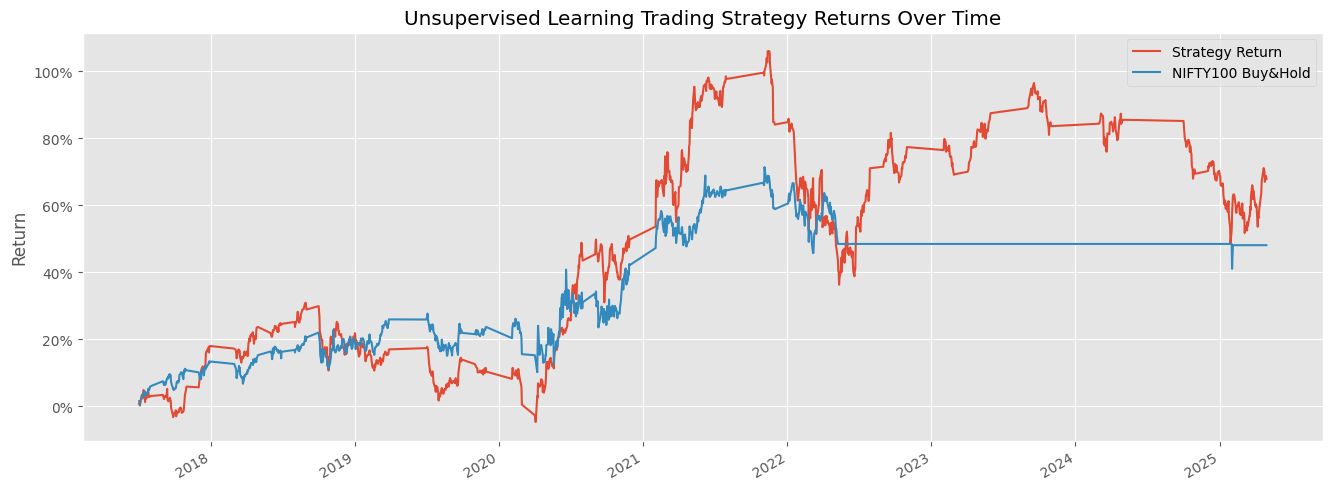

In [31]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-05-01'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


In [55]:
def evaluate_portfolio_performance(portfolio_returns, risk_free_rate=0.0):
    """
    Evaluate portfolio performance based on daily returns.

    Parameters:
    - portfolio_returns: DataFrame or Series of daily strategy returns (not cumulative)
    - risk_free_rate: Annual risk-free rate (e.g., 0.05 for 5%)

    Returns:
    - Dictionary of performance metrics
    """
    # If it's a DataFrame with multiple strategies, average them
    if isinstance(portfolio_returns, pd.DataFrame):
        daily_returns = portfolio_returns.mean(axis=1)
    else:
        daily_returns = portfolio_returns

    # Drop missing data
    daily_returns = daily_returns.dropna()

    # Compute metrics
    cumulative_return = (np.exp(np.log1p(daily_returns).cumsum())[-1]) - 1
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    annualized_return = np.mean(daily_returns) * 252
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    drawdown = (np.exp(np.log1p(daily_returns).cumsum()) / 
                np.exp(np.log1p(daily_returns).cumsum()).cummax()) - 1
    max_drawdown = drawdown.min()

    return {
        "Cumulative Return (%)": round(cumulative_return * 100, 2),
        "Annualized Return (%)": round(annualized_return * 100, 2),
        "Annualized Volatility (%)": round(annualized_volatility * 100, 2),
        "Sharpe Ratio": round(sharpe_ratio, 3),
        "Max Drawdown (%)": round(max_drawdown * 100, 2)
    }


In [58]:
metrics = evaluate_portfolio_performance(portfolio_df)
for meter in metrics.keys():
    print(meter ," : " ,metrics[meter])


Cumulative Return (%)  :  63.38
Annualized Return (%)  :  12.46
Annualized Volatility (%)  :  16.67
Sharpe Ratio  :  0.747
Max Drawdown (%)  :  -23.41
